#**NOTE**:

1.   Explanations are provided in English because Colab doesn't handle Persian correctly, and the structure of sentences gets messed up when we use both languages in the same sentence.


2.  Use GPU as the runtime; in the semi-supervised section, the graphs have been computed using the GPU.



3.  I uploaded the data from my Google Drive. If you want to run the code, make sure to change the file path accordingly (for convenience, the data is uploaded at the beginning of each cell for the models).







# **1. Data Loading and Importing Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import networkx as nx # This is for graph visualization
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/data_for_interview.csv'
df = pd.read_csv(file_path)

df.head()

,date,user,source_prefix,source_postfix,dest_prefix,dest_postfix,agent,amount,status,label
0,1701376212255,56757,Muffin,8267,Whiskers,4894,A,1000000,fail,0
1,1701376237246,19858,Squiggle,4947,Flapjack,9555,A,50000000,success,0
2,1701376237930,28303,Flapjack,8262,Squishy,566,C,2000000,success,0
3,1701376245611,23031,Squeegee,5657,Muffin,4559,C,9110000,fail,0
4,1701376256887,12391,Whiskers,1788,Snickerdoodle,9767,A,1000000,success,1


# **2. Datetime Conversion and Feature Extraction**

In [ ]:
df['date'] = pd.to_datetime(df['date'], unit='ms')

# Remove seconds
df['date'] = df['date'].dt.floor('T')

data = df.copy()

data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

data

,date,user,source_prefix,source_postfix,dest_prefix,dest_postfix,agent,amount,status,label,month,day,hour
0,2023-11-30 20:30:00,56757,Muffin,8267,Whiskers,4894,A,1000000,fail,0,11,30,20
1,2023-11-30 20:30:00,19858,Squiggle,4947,Flapjack,9555,A,50000000,success,0,11,30,20
2,2023-11-30 20:30:00,28303,Flapjack,8262,Squishy,566,C,2000000,success,0,11,30,20
3,2023-11-30 20:30:00,23031,Squeegee,5657,Muffin,4559,C,9110000,fail,0,11,30,20
4,2023-11-30 20:30:00,12391,Whiskers,1788,Snickerdoodle,9767,A,1000000,success,1,11,30,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106031,2023-12-14 20:29:00,31157,Squishy,3231,Waffles,4494,A,21500000,success,0,12,14,20
106032,2023-12-14 20:29:00,51293,Whiskers,1729,Squeegee,7487,C,22000000,success,0,12,14,20
106033,2023-12-14 20:29:00,43814,Whiskers,2569,Squeegee,1508,A,1000000,fail,0,12,14,20
106034,2023-12-14 20:29:00,29187,Bubbles,5533,Pancake,8330,C,2680000,success,0,12,14,20


##Output Overview

- **Columns**:
  - `date`: Datetime values truncated to minutes.
  - `user`: A unique identifier for users.
  - `source_prefix`, `source_postfix`, `dest_prefix`, `dest_postfix`: Representing source and destination attributes.
  - `agent`: Categorical variable with values like `A`, `C`, etc.
  - `amount`: Numerical variable indicating monetary amounts.
  - `status`: Categorical variable indicating transaction outcomes (`success` or `fail`).
  - `label`: Binary or categorical variable (likely indicating some classification).
  - `month`, `day`, `hour`: Newly added columns representing components of the `date`.

- **Shape**:
  - The dataset has `106,036 rows` and `13 columns`.



#**3. Checking Nulls and Data Types**

In [ ]:
data_info = {
    "Shape": data.shape,
    "Missing Values": data.isnull().sum(),
    "Data Types": data.dtypes
}
data_info

{'Shape': (106036, 13),
 'Missing Values': date              0
 user              0
 source_prefix     0
 source_postfix    0
 dest_prefix       0
 dest_postfix      0
 agent             0
 amount            0
 status            0
 label             0
 month             0
 day               0
 hour              0
 dtype: int64,
 'Data Types': date              datetime64[ns]
 user                       int64
 source_prefix             object
 source_postfix             int64
 dest_prefix               object
 dest_postfix               int64
 agent                     object
 amount                     int64
 status                    object
 label                      int64
 month                      int32
 day                        int32
 hour                       int32
 dtype: object}

##Output Overview
- **No** missing values are present in any of the columns.
- **Key Data Types**:
  - `date` (datetime64[ns]): Time-series analysis.
  - `amount` (int64): Transaction values for statistical and anomaly analysis.
  - `agent`, `status`, `source_prefix`, `dest_prefix` (object): Categorical variables for grouping and distributions.




# **4. Numerical and Categorical Summaries**

In [ ]:
numerical_summary = data.describe()

categorical_columns = data.select_dtypes(include=['object'])
categorical_summary = categorical_columns.describe()

print("Numerical Summary:")
display(numerical_summary)
print("\nCategorical Summary:")
display(categorical_summary)

Numerical Summary:


,date,user,source_postfix,dest_postfix,amount,label,month,day,hour
count,106036,106036.000000,106036.000000,106036.000000,1.060360e+05,106036.000000,106036.000000,106036.000000,106036.000000
mean,2023-12-08 01:39:09.106152704,31195.855653,4999.744285,5002.915783,5.329680e+06,0.034771,11.989881,7.816977,12.840120
min,2023-11-30 20:30:00,10000.000000,0.000000,0.000000,1.000000e+04,0.000000,11.000000,1.000000,0.000000
25%,2023-12-04 13:59:00,18529.000000,2500.000000,2494.000000,1.000000e+06,0.000000,12.000000,4.000000,9.000000
50%,2023-12-07 22:44:00,28727.500000,5011.000000,5019.000000,2.000000e+06,0.000000,12.000000,8.000000,13.000000
75%,2023-12-11 14:08:00,42430.250000,7496.250000,7463.000000,5.000000e+06,0.000000,12.000000,11.000000,17.000000
max,2023-12-14 20:29:00,62905.000000,9999.000000,9999.000000,5.000000e+07,1.000000,12.000000,30.000000,23.000000
std,NaN,14583.081300,2889.824627,2888.771782,9.148514e+06,0.183201,0.100084,4.574600,5.519979



Categorical Summary:


,source_prefix,dest_prefix,agent,status
count,106036,106036,106036,106036
unique,27,34,4,2
top,Whiskers,Whiskers,A,success
freq,32565,18966,60279,71541


## Numerical Summary:
1. **Key Metrics**:
   - **`amount`**:
     - Mean: 5,329,680
     - Minimum: 10,000
     - Maximum: 50,000,000
     - High standard deviation (9,148,514), indicating significant variability.
     - 50% of transactions have values below 2,000,000 (median).

   - **Temporal Variables**:
     - The data spans from `2023-11-30` to `2023-12-14`.
     - Most transactions occur during daytime hours (`hour` median: 13, max: 23).

2. **Insights for Modeling**:
  
   - Temporal patterns (e.g. hourly peaks) can be valuable for feature engineering, such as adding `is_peak_hour` or `is_weekend`.

## Categorical Summary:
1. **Key Observations**:
   - **`agent`**:
     - Four unique agents, with `A` performing the majority of transactions (60,279 occurrences).
   - **`status`**:
     - Dominated by `success` transactions (71,541 occurrences).
   - **`label`**:
     - Indicates fraud detection:
       - Fraudulent transactions account for only 3.5% of the dataset, suggesting a significant class imbalance.
   - **`source_prefix` and `dest_prefix`**:
     - Highly diverse categories (27 and 34 unique values respectively), with `Whiskers` being the most common in both.

2. **Insights for Fraud Detection**:
   - The imbalance in `label` requires addressing to prevent the model from being biased toward the majority class (non-fraudulent).
   - Frequent categories in `source_prefix` and `dest_prefix` may indicate recurring patterns in fraudulent or legitimate transactions.


# **5. Fraud and Normal Transactions Analysis**

## Box Plots

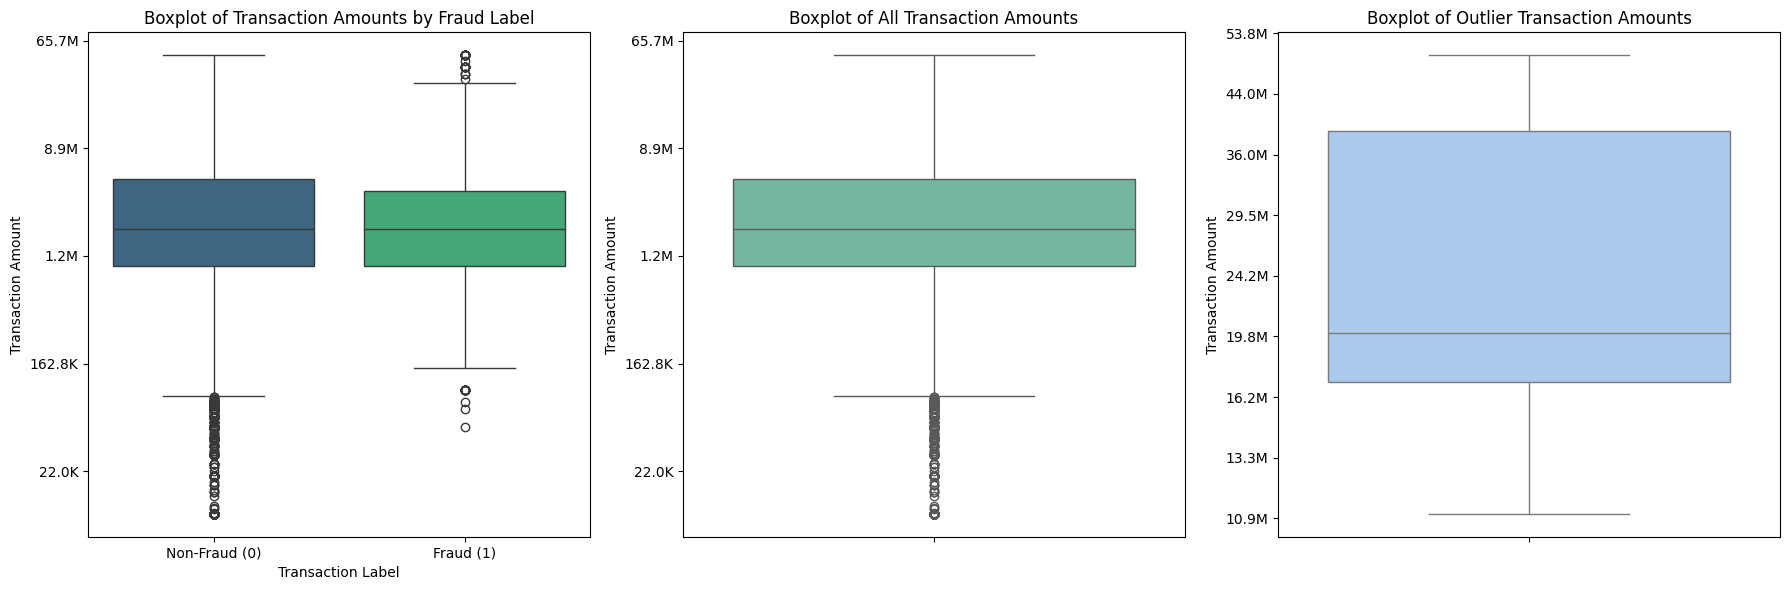

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


data['log_amount'] = np.log1p(data['amount'])

# Modify the plot to display transaction amounts in millions

def format_ticks(value, pos):
    original_amount = np.expm1(value)
    if original_amount >= 1e9:
        return f'{original_amount / 1e9:.1f}B'  # Show as billions
    elif original_amount >= 1e6:
        return f'{original_amount / 1e6:.1f}M'  # Show as millions
    else:
        return f'{original_amount / 1e3:.1f}K'  # Show as thousands

# Calculate outliers
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['amount'] < (Q1 - 1.5 * IQR)) | (data['amount'] > (Q3 + 1.5 * IQR))]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for transactions by fraud label
sns.boxplot(x='label', y='log_amount', data=data, palette='viridis', ax=axes[0])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Fraud (0)', 'Fraud (1)'])
axes[0].set_xlabel('Transaction Label')
axes[0].set_ylabel('Transaction Amount')
axes[0].set_title('Boxplot of Transaction Amounts by Fraud Label')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_ticks))

# Box plot for all transactions
sns.boxplot(y='log_amount', data=data, palette='Set2', ax=axes[1])
axes[1].set_ylabel('Transaction Amount')
axes[1].set_title('Boxplot of All Transaction Amounts')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(format_ticks))

# Box plot for outliers
sns.boxplot(y='log_amount', data=outliers, palette='pastel', ax=axes[2])
axes[2].set_ylabel('Transaction Amount')
axes[2].set_title('Boxplot of Outlier Transaction Amounts')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(format_ticks))


plt.tight_layout()
plt.show()

##  Key Observations:
1. **Boxplot of Transaction Amounts by Fraud Label**:
   - Fraudulent transactions (label `1`) and non-fraudulent transactions (label `0`) share overlapping ranges in transaction amounts.
   - The overlap across nearly all ranges of transaction amounts, except for very low values, suggests that transaction amount alone may not be a strong discriminator for fraud detection.

2. **Boxplot of All Transaction Amounts**:
   - While the majority of transactions are concentrated below approximately 9M, both fraudulent and non-fraudulent transactions extend up to the maximum range of 50M.
   - This overlap reduces the predictive power of `amount` as a standalone feature.

3. **Boxplot of Outlier Transaction Amounts**:
   - High-value transactions (greater than 10M) do occur for both fraudulent and non-fraudulent cases.
   - Only **1.58%** of high-value transactions are fraudulent, further demonstrating that high transaction amounts are not sufficient for reliable fraud detection.

---

## Insights for Fraud Detection:
- **Transaction Amounts as Predictors**:
  - Transaction amount may not be a strong standalone feature for detecting fraud due to the wide overlap between fraud and non-fraud transactions.
  - However, very low transaction amounts are rarely fraudulent, suggesting that thresholds for low values could help rule out fraud in some cases.



## Fraud Outliers Information

In [ ]:
non_fraud_data = data[data['label'] == 0]
fraud_data = data[data['label'] == 1]

Q1_non_fraud = non_fraud_data['amount'].quantile(0.25)
Q3_non_fraud = non_fraud_data['amount'].quantile(0.75)
IQR_non_fraud = Q3_non_fraud - Q1_non_fraud
non_fraud_upper_bound = Q3_non_fraud + 1.5 * IQR_non_fraud

Q1_fraud = fraud_data['amount'].quantile(0.25)
Q3_fraud = fraud_data['amount'].quantile(0.75)
IQR_fraud = Q3_fraud - Q1_fraud
fraud_upper_bound = Q3_fraud + 1.5 * IQR_fraud


# Outliers are defined as amounts greater than the upper bound
non_fraud_outliers = data[(data['label'] == 0) & (data['amount'] > non_fraud_upper_bound)]
fraud_outliers = data[(data['label'] == 1) & (data['amount'] > fraud_upper_bound)]


total_outliers = len(non_fraud_outliers) + len(fraud_outliers)
fraud_outlier_percentage = (len(fraud_outliers) / total_outliers) * 100 if total_outliers > 0 else 0

outlier_summary = {
    "Total Outliers": total_outliers,
    "Fraud Outliers": len(fraud_outliers),
    "Non-Fraud Outliers": len(non_fraud_outliers),
    "Percentage of Fraud Outliers": f"{fraud_outlier_percentage:.2f}%"
}

outlier_summary

{'Total Outliers': 11749,
 'Fraud Outliers': 426,
 'Non-Fraud Outliers': 11323,
 'Percentage of Fraud Outliers': '3.63%'}

- The low percentage of fraudulent outliers suggests that being an outlier in transaction amount is not a definitive indicator of fraud.

##Visualizing Fraudulent and Normal Transactions

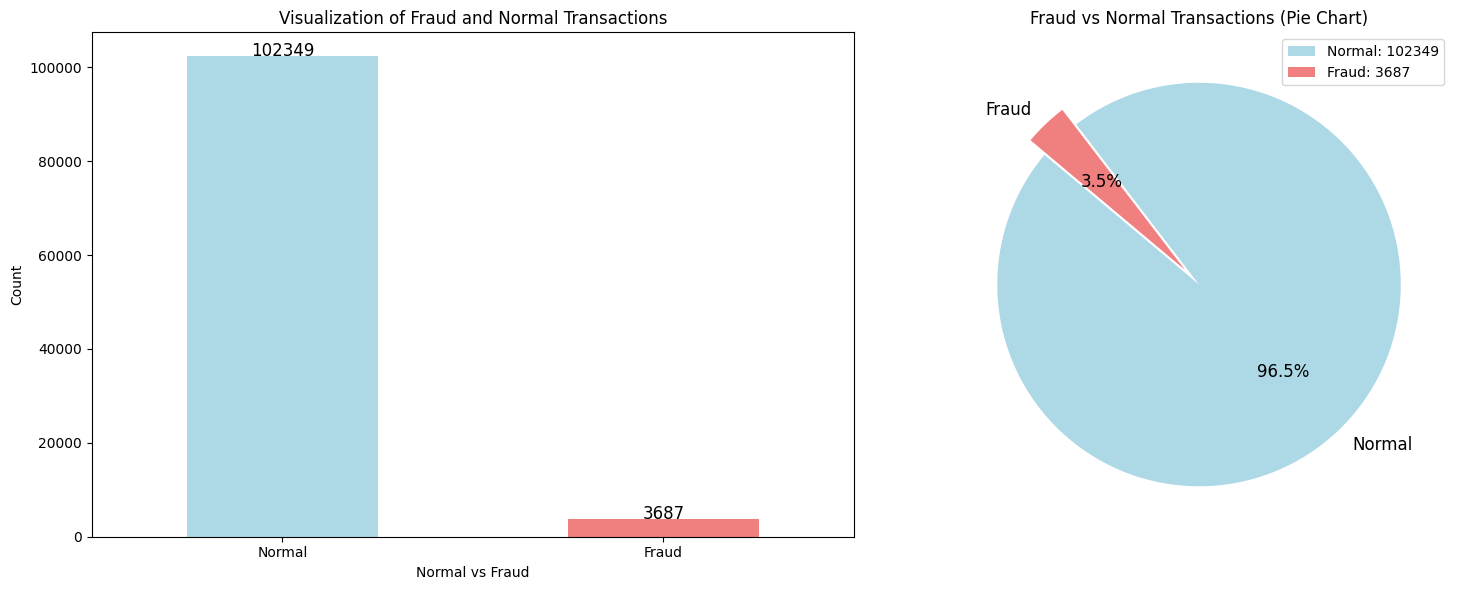

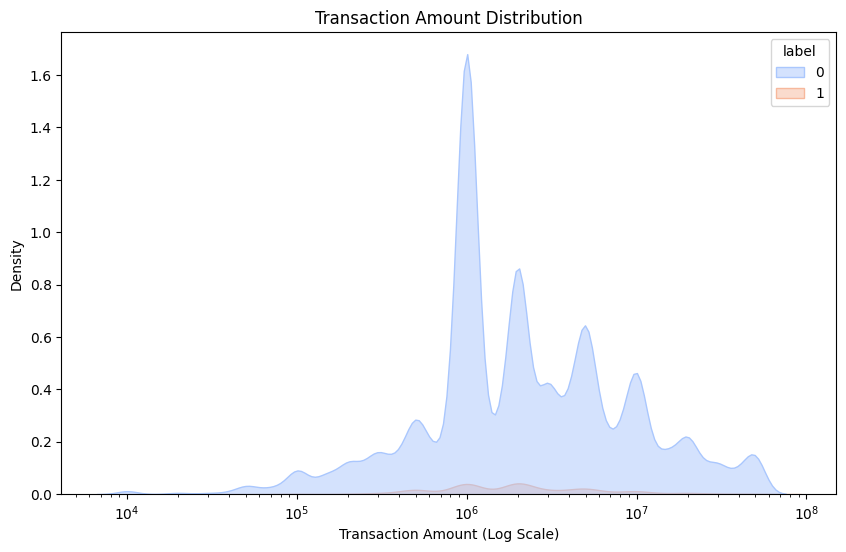

In [ ]:
count_classes = pd.value_counts(data['label'], sort=True)
labels = ['Normal', 'Fraud']



fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
bars = count_classes.plot(kind="bar", rot=0, color=["lightblue", "lightcoral"], ax=axes[0])
axes[0].set_title("Visualization of Fraud and Normal Transactions")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Normal vs Fraud")
axes[0].set_xticks(range(2))
axes[0].set_xticklabels(labels)

# Annotate the bars with their respective counts
for index, value in enumerate(count_classes):
    axes[0].text(index, value + 100, str(value), ha='center', fontsize=12, color='black')

# Pie chart
explode = (0, 0.1)  # Slightly explode the "Fraud" slice for emphasis
colors = ["lightblue", "lightcoral"]  # Lighter shades of blue and red

axes[1].pie(
    count_classes,
    labels=labels,
    autopct='%1.1f%%',  # Display percentage
    startangle=140,
    explode=explode,
    colors=colors,
    textprops={'fontsize': 12}
)

axes[1].set_title("Fraud vs Normal Transactions (Pie Chart)")
axes[1].legend(labels=[f"{label}: {count}" for label, count in zip(labels, count_classes)], loc="upper right")


plt.tight_layout()


plt.show()


plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='amount', hue='label', log_scale=True, fill=True, palette='coolwarm', alpha=0.5)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount (Log Scale)')
plt.ylabel('Density')
plt.show()

### Fraud vs. Normal Transactions (Bar and Pie Charts):
1. **Distribution**:

   - The dataset is highly imbalanced, with fraudulent transactions being a small minority.

2. **Insights**:
   - The significant class imbalance suggests that the model must account for this disparity, such as using **weighted loss functions or resampling techniques.**
   
---

### Transaction Amount Distribution (Log Scale Density Plot):
1. **Non-Fraudulent Transactions (Label 0)**:
   - Most transactions are concentrated in the mid-range amounts (around \(10^5 - 10^6\)).
   - The density decreases gradually as transaction amounts increase.

2. **Fraudulent Transactions (Label 1)**:
   
   - Fraud does not seem confined to any specific transaction range, further supporting the need for additional distinguishing features.

3. **Insights**:
   - The overlap in the distribution of fraudulent and non-fraudulent transactions highlights that transaction amount alone is insufficient for predicting fraud.
   - Transforming transaction amounts (e.g., log transformation) could enhance model performance by reducing the influence of outliers.

---

## Recommendations for Modeling:
1. **Handling Imbalance**:
   - We can use techniques like SMOTE, oversampling, or undersampling to address the 3.5% fraud class.
   - We should consider using precision-recall or AUROC metrics for evaluation, as accuracy may be misleading due to the class imbalance.


#6.Correlation Matrix

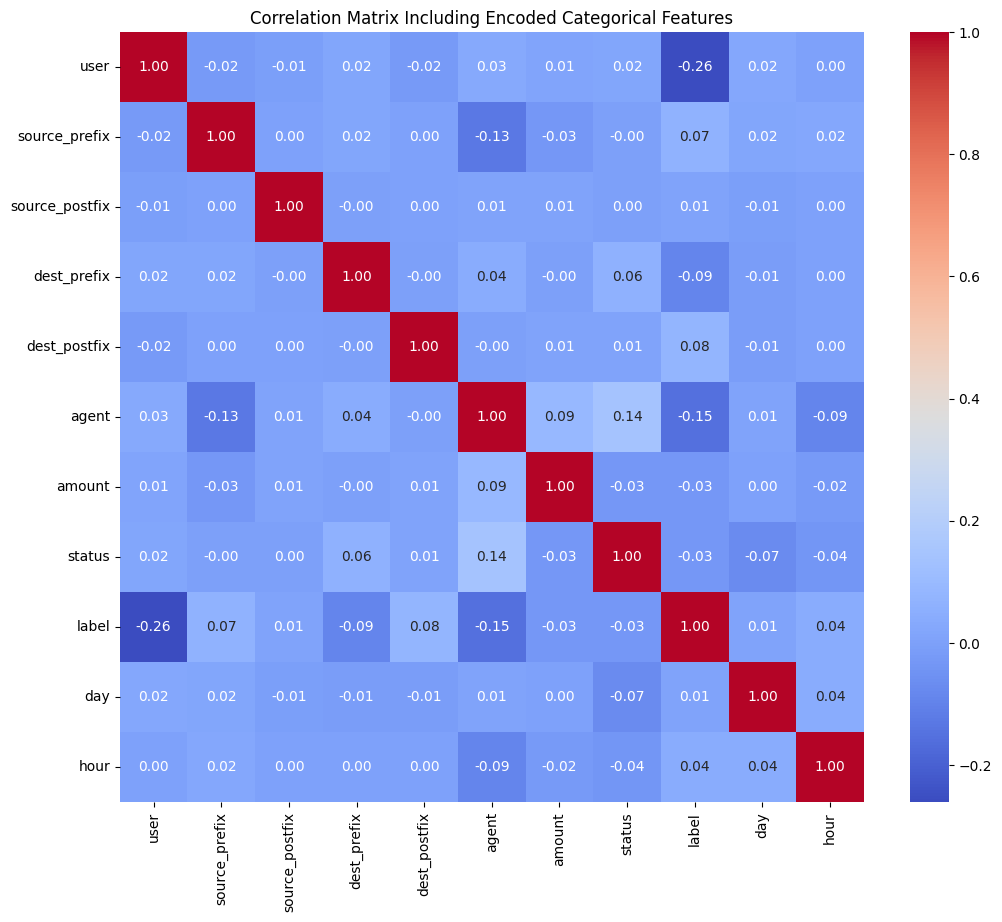

In [ ]:
data_encoded = data.copy()

# Encode string columns to numerical
for column in data_encoded.select_dtypes(include=['object']).columns:
    data_encoded[column] = data_encoded[column].astype('category').cat.codes


if data_encoded['label'].dtype == 'object':
    data_encoded['label'] = data_encoded['label'].astype('category').cat.codes

# year and month is approximatly same for all data
columns_to_exclude = ['date','year', 'month','log_amount']
data_encoded = data_encoded.drop(columns=columns_to_exclude, axis=1, errors='ignore')


correlation_matrix = data_encoded.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Including Encoded Categorical Features')
plt.show()


# Correlation Matrix Analysis

## Key Observations:
1. **`label` (Fraud Indicator)**:
   - **Moderate Negative Correlation with `user` (-0.26)**:
     - Indicates that user-specific patterns may contribute to identifying fraudulent transactions.
   - Weak correlations with other features suggest that no single feature strongly predicts fraud on its own.

2. **Other Feature Relationships**:
   - **`agent` and `label`**:
     - A weak correlation (~0.08), implying minimal direct impact of the `agent` on fraud detection.
   - **`source_prefix`, `dest_prefix`, and `label`**:
     - Very weak positive correlations (~0.07–0.08), suggesting that source and destination prefixes alone may not be strong indicators of fraud.




3. **Overall Correlation**:
   - Most features show very low correlations with each other and with the fraud label, highlighting the potential need for combining multiple features or using advanced methods (e.g., interaction terms or machine learning models) to improve prediction.

---

## Recommendations:

- We can create interaction features between weakly correlated variables (e.g., `agent` and `source_prefix`) to uncover non-linear relationships.



- Using tree-based models (e.g., Random Forest, XGBoost) can handle weakly correlated and non-linear relationships effectively.

- We can Drop `source_postfix` and `dest_postfix` as they show negligible importance in predicting fraud, simplifying the dataset.
  

# 7.Numerical and Categorical Summaries for fraud rows

In [ ]:
data=data.drop(columns=['log_amount'])

fraud_data = data[data['label'] == 1]


fraud_num = fraud_data.describe()
fraud_cat = fraud_data.describe(include=['object'])

print("Numerical Summary of Fraudulent Transactions:")
display(fraud_num)

print("\nCategorical Summary of Fraudulent Transactions:")
display(fraud_cat)



Numerical Summary of Fraudulent Transactions:


,date,user,source_postfix,dest_postfix,amount,label,month,day,hour
count,3687,3687.000000,3687.000000,3687.000000,3.687000e+03,3687.0,3687.000000,3687.000000,3687.000000
mean,2023-12-08 03:21:27.681041664,11149.471115,5110.973420,6186.534581,3.755891e+06,1.0,11.986168,7.946840,14.089232
min,2023-11-30 20:30:00,10000.000000,4.000000,144.000000,5.000000e+04,1.0,11.000000,1.000000,0.000000
25%,2023-12-05 22:26:30,10521.000000,2662.500000,3853.000000,1.000000e+06,1.0,12.000000,6.000000,8.000000
50%,2023-12-08 11:27:00,11116.000000,5169.000000,6719.000000,2.000000e+06,1.0,12.000000,8.000000,16.000000
75%,2023-12-10 19:27:30,11775.500000,7615.500000,8567.000000,4.000000e+06,1.0,12.000000,10.000000,20.000000
max,2023-12-14 18:50:00,12391.000000,9999.000000,9922.000000,5.000000e+07,1.0,12.000000,30.000000,23.000000
std,NaN,703.994639,2832.876169,2790.766380,5.968818e+06,0.0,0.116811,4.045173,7.161490



Categorical Summary of Fraudulent Transactions:


,source_prefix,dest_prefix,agent,status
count,3687,3687,3687,3687
unique,26,14,4,2
top,Whiskers,Buttercup,A,success
freq,1679,857,3523,2192


# Summary of Fraudulent Transactions

## Numerical Summary:
1. **Transaction Counts**:
   - Total fraudulent transactions: **3,687**.

2. **Amount**:
   - **Mean**: 3,755,891.
   - **Median (50%)**: 2,000,000.
   - **Minimum**: 50,000.
   - **Maximum**: 50,000,000.
   - **Standard Deviation**: 5,968,818, indicating high variability in fraudulent transaction amounts.


---

## Categorical Summary:
1. **Source Prefix**:
   - **Unique Values**: 26.
   - **Most Frequent Source**: `Whiskers` with **1,679 transactions**.

2. **Destination Prefix**:
   - **Unique Values**: 14.
   - **Most Frequent Destination**: `Buttercup` with **857 transactions**.

3. **Agent**:
   - **Unique Values**: 4.
   - **Most Frequent Agent**: `A` with **3,523 transactions**.

4. **Status**:
   - **Most Frequent Status**: `Success` with **2,192 transactions**.

---

## Key Insights:


1. **Source and Destination**:
   - Specific prefixes (`Whiskers` and `Buttercup`) dominate fraudulent transactions, indicating potential high-risk entities.

2. **Agent and Status**:
   - Most fraudulent transactions are processed by `Agent A` and marked as `Success`, suggesting these attributes may correlate with fraud.

---

## Recommendations:
1. **Focus on Key Attributes**:
   - We should consider high-risk prefixes like (`Whiskers`, `Buttercup`) and agents (`A`) in our model.
  



# 8.Temporal Analysis of Fraudulent Transactions

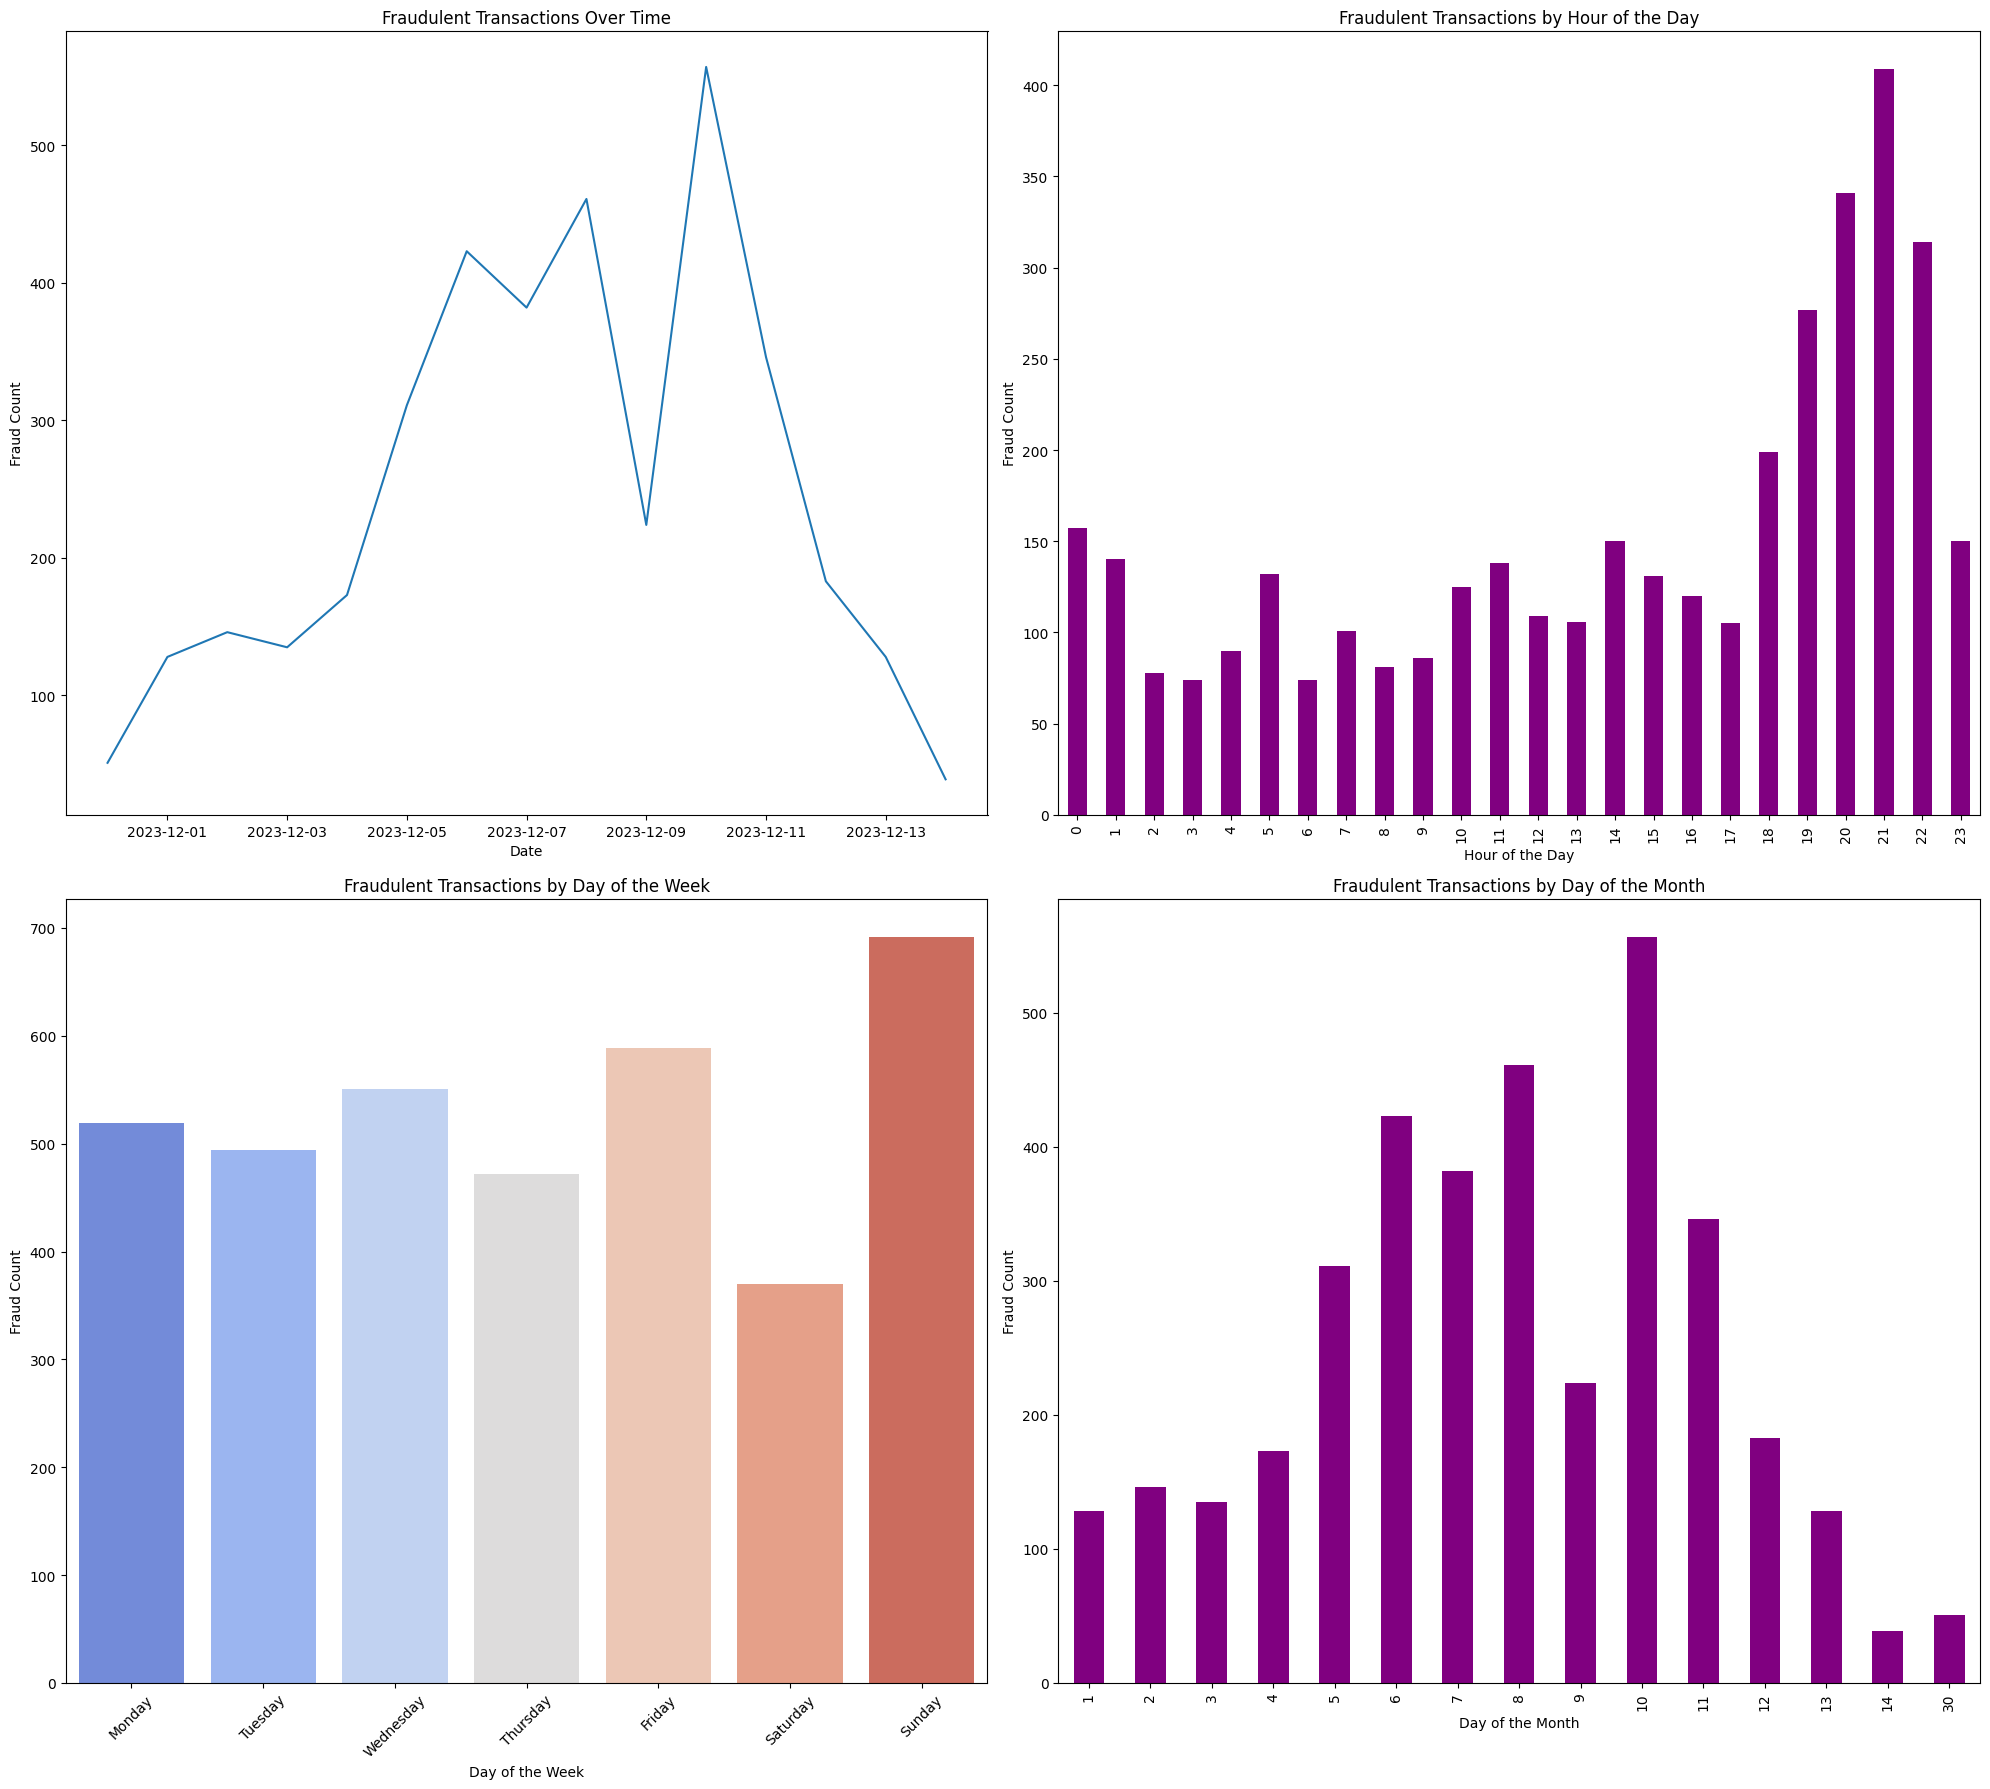

In [ ]:
fraud_data = data[data['label'] == 1]


fig, axes = plt.subplots(2, 2, figsize=(20, 18))  # 2 rows, 2 columns


#Fraud distribution over time
fraud_data.groupby(fraud_data['date'].dt.date)['label'].count().plot(ax=axes[0, 0])
axes[0, 0].set_title('Fraudulent Transactions Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Fraud Count')


#Fraud occurrence by hour of the day
fraud_by_hour = fraud_data['date'].dt.hour.value_counts().sort_index()
fraud_by_hour.plot(kind='bar', color='purple', ax=axes[0, 1])  # Changed to axes[0, 1]
axes[0, 1].set_title('Fraudulent Transactions by Hour of the Day')
axes[0, 1].set_xlabel('Hour of the Day')
axes[0, 1].set_ylabel('Fraud Count')


fraud_data['day_of_week'] = fraud_data['date'].dt.day_name()
fraud_data['day_of_month'] = fraud_data['date'].dt.day

# Fraudulent transactions by day of the week
fraud_by_weekday = fraud_data['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
sns.barplot(x=fraud_by_weekday.index, y=fraud_by_weekday.values, palette='coolwarm', ax=axes[1, 0]) # Changed to axes[1, 0]
axes[1, 0].set_title('Fraudulent Transactions by Day of the Week')
axes[1, 0].set_xlabel('Day of the Week')
axes[1, 0].set_ylabel('Fraud Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Fraudulent transactions by day of the month
fraud_by_day = fraud_data['day_of_month'].value_counts().sort_index()
fraud_by_day.plot(kind='bar', color='purple', ax=axes[1, 1])  # Changed to axes[1, 1]
axes[1, 1].set_title('Fraudulent Transactions by Day of the Month')
axes[1, 1].set_xlabel('Day of the Month')
axes[1, 1].set_ylabel('Fraud Count')



plt.tight_layout()
plt.show()

## Key Observations:
1. **Fraudulent Transactions Over Time**:
   - Fraud cases peaked around **2023-12-09** with over **500 transactions** in a single day.
   - A rapid decline is observed after the peak, possibly indicating a mitigation response or system adjustment.

2. **Fraudulent Transactions by Hour of the Day**:
   - Fraud activity is highest during **20:00–22:00**, with significant activity starting around **18:00** and declining after midnight.
   - Early morning hours (02:00–07:00) exhibit the least fraudulent activity.



---

## Insights:
- **Temporal Patterns**:
- Fraud tends to occur more frequently during specific times of the day
so we can create binary features for:
       - `is_peak_hour`: 1 if transaction time is between 18:00–22:00, 0 otherwise.

- As our highest and lowest transaction amounts are both on the weekend (I assume this data belongs to a foreign country), we can't use the weekend as a feature.   

##High-Frequency Fraud Analysis with a 2-Minute Time Window

In [ ]:
data['time_window'] = data['date'].dt.floor('2min')


combined_time_window_analysis = data.melt(
    id_vars=['time_window', 'label'],
    value_vars=['source_prefix', 'dest_prefix'],
    var_name='type',
    value_name='prefix'
)

# Group by prefix, type, and time window, counting transactions and frauds
combined_analysis = combined_time_window_analysis.groupby(['prefix', 'type', 'time_window']).agg(
    total_transactions=('label', 'count'),
    fraud_transactions=('label', lambda x: (x == 1).sum())
).reset_index()

# Calculate fraud percentage
combined_analysis['fraud_percentage'] = (
    combined_analysis['fraud_transactions'] / combined_analysis['total_transactions']
) * 100

# Filter for high-frequency cases with more than 10 transactions in a 2-minute window
high_frequency_combined = combined_analysis[combined_analysis['total_transactions'] > 10]


updated_combined_stats_2min = high_frequency_combined.groupby('type').agg(
    total_cases=('time_window', 'count'),
    cases_with_fraud=('fraud_transactions', lambda x: (x > 0).sum()),
    percentage_with_fraud=('fraud_transactions', lambda x: (x > 0).sum() / len(x) * 100)
).reset_index()

print("High-Frequency Fraud Analysis within a 2-Minute Time Window")

display(updated_combined_stats_2min)


,type,total_cases,cases_with_fraud,percentage_with_fraud
0,dest_prefix,8,4,50.0
1,source_prefix,110,44,40.0


- High transaction frequency within a short 2-minute window is a strong potential indicator of fraudulent activity, with 40-50% of such cases involving fraud.




#9.Fraudulent Transaction Patterns: Amount, Prefix Relationships, and Agent Analysis"

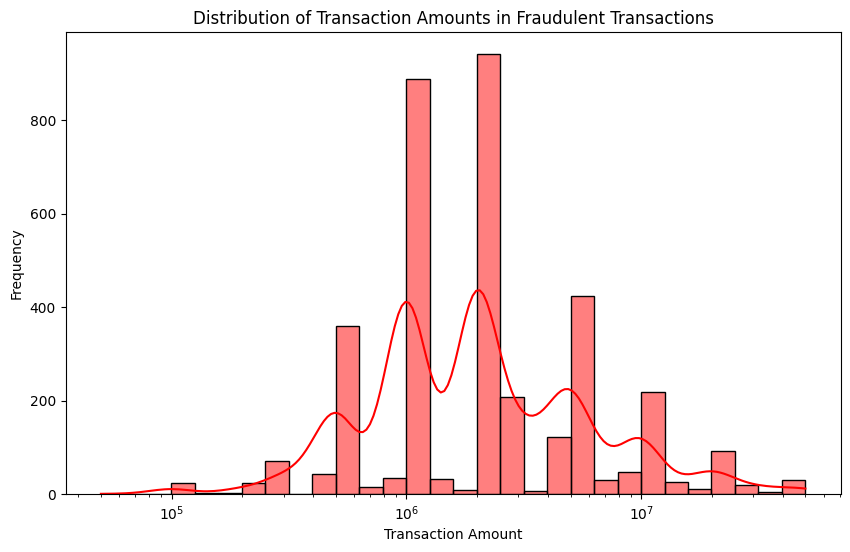

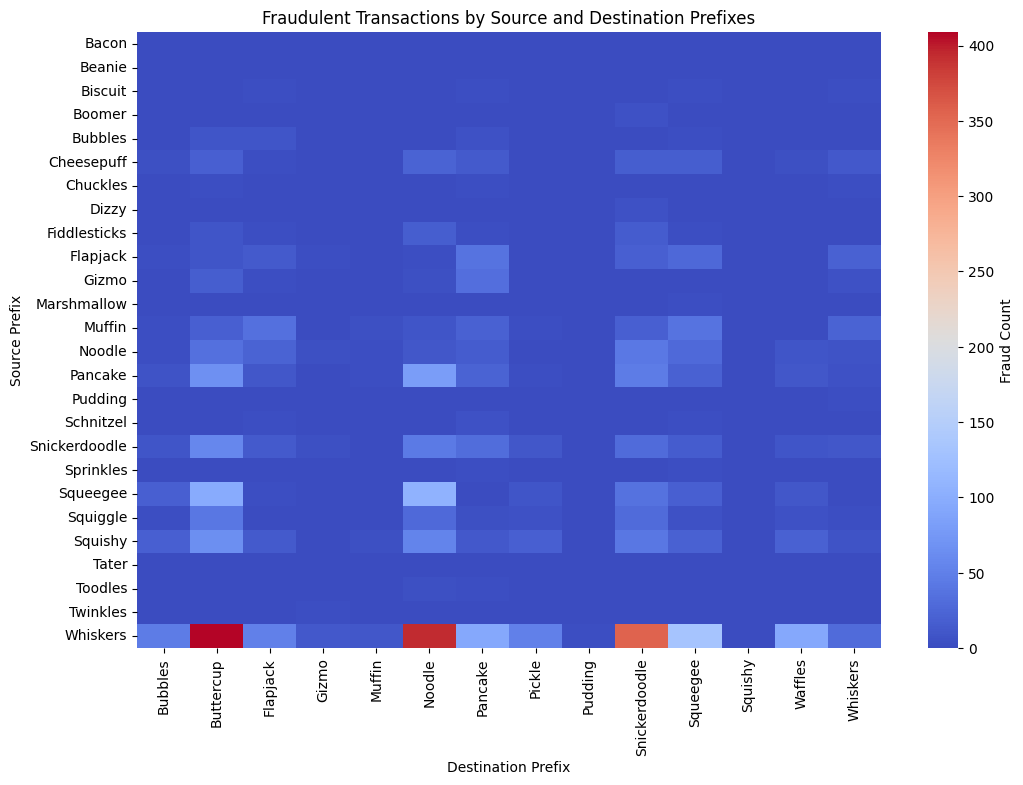

<Figure size 640x480 with 0 Axes>

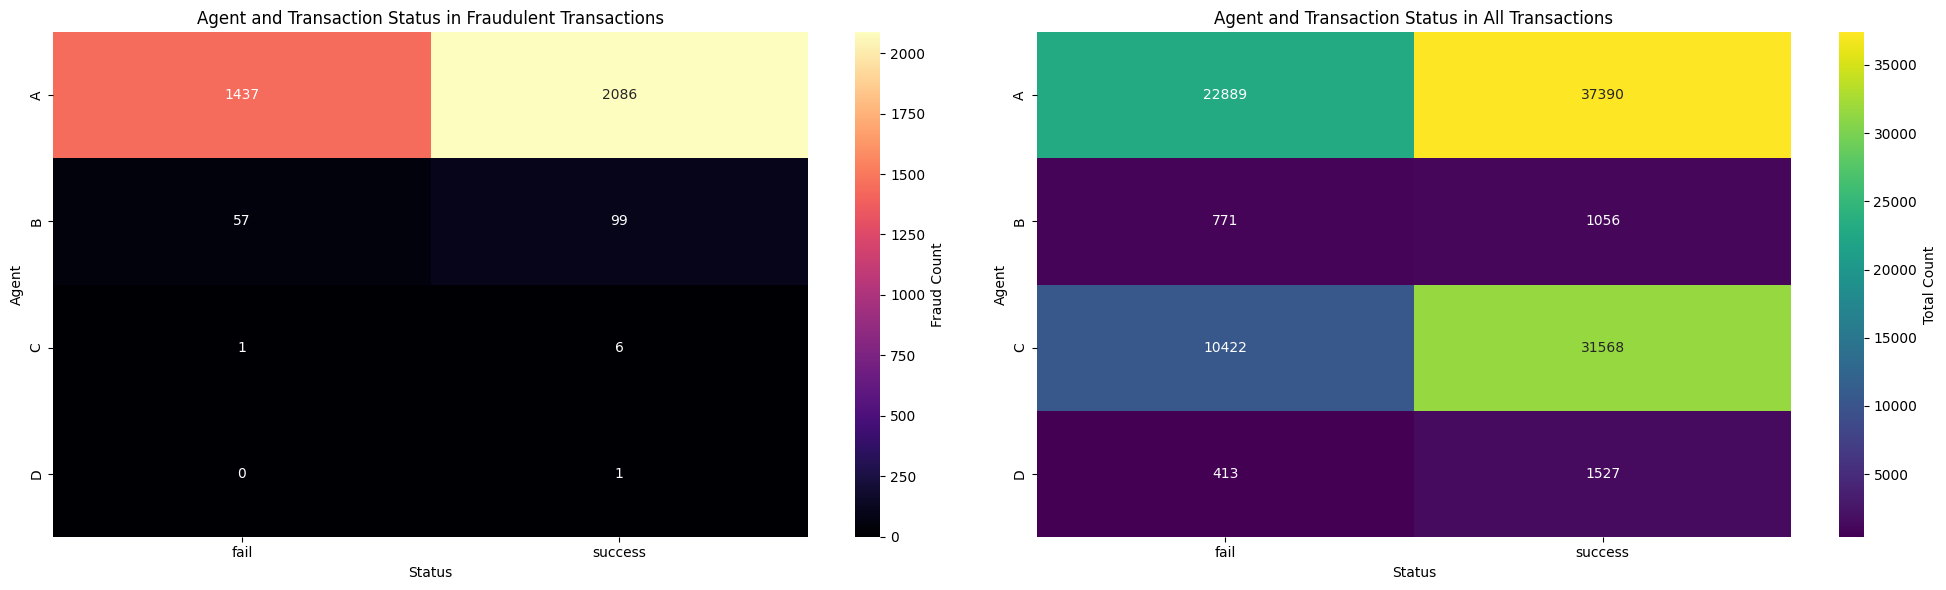

In [ ]:
#Fraudulent transaction amount distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(fraud_data['amount'], bins=30, kde=True, log_scale=True, color='red', ax=ax)
ax.set_title('Distribution of Transaction Amounts in Fraudulent Transactions')
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('Frequency')


# Heatmap for Source vs. Destination Prefixes in Fraud Cases
fraud_source_dest = fraud_data.groupby(['source_prefix', 'dest_prefix']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_source_dest, cmap='coolwarm', cbar_kws={'label': 'Fraud Count'})
plt.title('Fraudulent Transactions by Source and Destination Prefixes')
plt.xlabel('Destination Prefix')
plt.ylabel('Source Prefix')
plt.show()

plt.subplots_adjust(bottom=0.1)


fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Agent Patterns in Fraud
sns.heatmap(pd.crosstab(fraud_data['agent'], fraud_data['status']),
            annot=True,
            cmap='magma',
            cbar_kws={'label': 'Fraud Count'},
            fmt='g',
            ax=axes[0])
axes[0].set_title('Agent and Transaction Status in Fraudulent Transactions')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Agent')

#Agent Patterns in All Transactions
sns.heatmap(pd.crosstab(data['agent'], data['status']),
            annot=True,
            cmap='viridis',
            cbar_kws={'label': 'Total Count'},
            fmt='g',
            ax=axes[1])
axes[1].set_title('Agent and Transaction Status in All Transactions')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('Agent')

plt.tight_layout()
plt.show()

## Insights:

### 1. **Distribution of Transaction Amounts in Fraudulent Transactions**:

   - The log scale of the x-axis indicates fraud is not restricted to high amounts but also occurs in mid-range values.

### 2. **Fraudulent Transactions by Source and Destination Prefixes**:
   - Certain `source_prefix` and `dest_prefix` combinations are highly associated with fraud, as highlighted by the heatmap.
   - Prefixes like `Whiskers`, `Buttercup`, and `Snickerdoodle` frequently occur in fraudulent cases, suggesting targeted scrutiny.

### 3. **Agent and Transaction Status in Fraudulent Transactions**:
   - Fraudulent transactions are predominantly processed by `Agent A`, with the majority being marked as `success`.
   - Agents `B`, `C`, and `D` have minimal association with fraudulent transactions.

   -  Since fraud occurs almost equally in `success` transactions, this feature adds little value and can be excluded to simplify the model.

### 4. **Agent and Transaction Status in All Transactions**:
   - `Agent A` also dominates in overall transactions, but its association with fraud is disproportionate compared to other agents.

---

## Recommendations:



### 1. **Prefix-Based Monitoring**:
   - We can Prioritize using transactions involving high-risk prefix combinations identified in the heatmap.
   - Include features like `is_high_risk_prefix_pair` in fraud detection models.


   

### 2. **Model Features**:
   - we can use `amount`, `source_prefix`, `dest_prefix`, and agent-related features as key predictors.
   
### 3. **System Enhancements**:
   - (in a real world scenario) we can Develop automated alerts for suspicious prefix combinations and agent behaviors.


#10.Path analysis

##paths that were used by a specific user many times for fraud

In [ ]:
user_path_analysis = (
    fraud_data.groupby(['user','source_prefix', 'dest_prefix', 'agent'])
    .size()
    .reset_index(name='fraud_count')
    .sort_values(by='fraud_count', ascending=False)
)

user_path_analysis.reset_index(drop=True, inplace=True)

print("paths that were used by a specific user many times for fraud")

display(user_path_analysis.head(15))


paths that were used by a specific user many times for fraud


,user,source_prefix,dest_prefix,agent,fraud_count
0,10048,Whiskers,Buttercup,A,15
1,12105,Whiskers,Pancake,A,12
2,11133,Whiskers,Noodle,A,12
3,10298,Whiskers,Noodle,A,10
4,10340,Pancake,Noodle,A,10
5,10521,Squishy,Buttercup,A,9
6,10119,Squeegee,Noodle,A,9
7,10551,Whiskers,Noodle,A,9
8,10452,Squeegee,Buttercup,A,9
9,12045,Whiskers,Buttercup,A,8


##paths that were used many times for fraud

In [ ]:
fraud_path_analysis = (
    fraud_data.groupby(['source_prefix', 'dest_prefix', 'agent'])
    .size()
    .reset_index(name='fraud_count')
    .sort_values(by='fraud_count', ascending=False)
)

fraud_path_analysis.reset_index(drop=True, inplace=True)

print("paths that were used many times for fraud")
display(fraud_path_analysis.head(15))

paths that were used many times for fraud


,source_prefix,dest_prefix,agent,fraud_count
0,Whiskers,Noodle,A,394
1,Whiskers,Buttercup,A,388
2,Whiskers,Snickerdoodle,A,356
3,Whiskers,Squeegee,A,132
4,Squeegee,Noodle,A,107
5,Whiskers,Pancake,A,93
6,Whiskers,Waffles,A,93
7,Squeegee,Buttercup,A,85
8,Pancake,Noodle,A,81
9,Pancake,Buttercup,A,58


##Commonly Fraudulent Paths for Agents

In [ ]:
fraud_b = (
    fraud_data[fraud_data['agent'] == 'B']
    .groupby(['source_prefix', 'dest_prefix'])
    .size()
    .reset_index(name='fraud_count')
    .sort_values(by='fraud_count', ascending=False)
)

fraud_c = (
    fraud_data[fraud_data['agent'] == 'C']
    .groupby(['source_prefix', 'dest_prefix'])
    .size()
    .reset_index(name='fraud_count')
    .sort_values(by='fraud_count', ascending=False)
)
fraud_c.reset_index(drop=True, inplace=True)
fraud_b.reset_index(drop=True, inplace=True)

display(Markdown("### **Fraudulent Paths Using Agent B**"))
display(fraud_b.head(15))


print("\n" * 2)


display(Markdown("### **Fraudulent Paths Using Agent C**"))
display(fraud_c.head(15))


### **Fraudulent Paths Using Agent B**

,source_prefix,dest_prefix,fraud_count
0,Whiskers,Buttercup,21
1,Snickerdoodle,Buttercup,17
2,Squishy,Buttercup,15
3,Gizmo,Buttercup,15
4,Noodle,Buttercup,12
5,Muffin,Buttercup,12
6,Squeegee,Buttercup,12
7,Flapjack,Buttercup,9
8,Bubbles,Buttercup,9
9,Pancake,Buttercup,9


### **Fraudulent Paths Using Agent C**

,source_prefix,dest_prefix,fraud_count
0,Noodle,Buttercup,3
1,Bubbles,Noodle,1
2,Gizmo,Buttercup,1
3,Squeegee,Muffin,1
4,Squishy,Buttercup,1




##Conclusion: Summary of Path Analysis

## Key Findings:
1. **Dominance of `Whiskers` as Source**:
   - Across all agents, `Whiskers` consistently appears as the most frequent `source_prefix` in high-risk paths.
   - This indicates that `Whiskers` is a critical node in fraudulent transaction networks.

2. **Concentration on Specific Destinations**:
   - `Buttercup`, `Noodle`, and `Snickerdoodle` are the most targeted `dest_prefixes`, often paired with high-risk sources like `Whiskers` and `Squeegee`.

3. **Agent-Specific Trends**:
   - **Agent A** is responsible for the majority of fraudulent paths, with repeated transactions across high-risk paths.
   - **Agent B** also shows significant fraudulent activity but is less dominant than Agent A, focusing heavily on paths leading to `Buttercup`.
   - **Agent C** has minimal fraudulent activity, with scattered and infrequent paths.

4. **High-Risk Path Patterns**:
   - Certain combinations of `source_prefix` and `dest_prefix` (e.g., `Whiskers -> Buttercup`, `Squeegee -> Noodle`) repeatedly appear in fraud cases, making them strong indicators for detection.

5. **User-Specific Behavior**:
   - Some users are associated with repeated high-risk paths, suggesting organized fraud operations or systemic exploitation of vulnerabilities.

---

## Implications:
- Fraudulent activity is highly concentrated on specific sources and destinations, with particular agents facilitating these transactions.
- Using these high-risk paths and agents can significantly helpful in building models.

---

## Recommendations:
1. **High-Risk Path Identification**:
   - Flag transactions involving frequently observed fraudulent paths for additional scrutiny.


2. **Dynamic Features for Fraud Detection**:
   - Use path frequency, user behavior, and agent involvement as predictive features in fraud detection models.



#11. Fraudulent Transactions Network Visualization

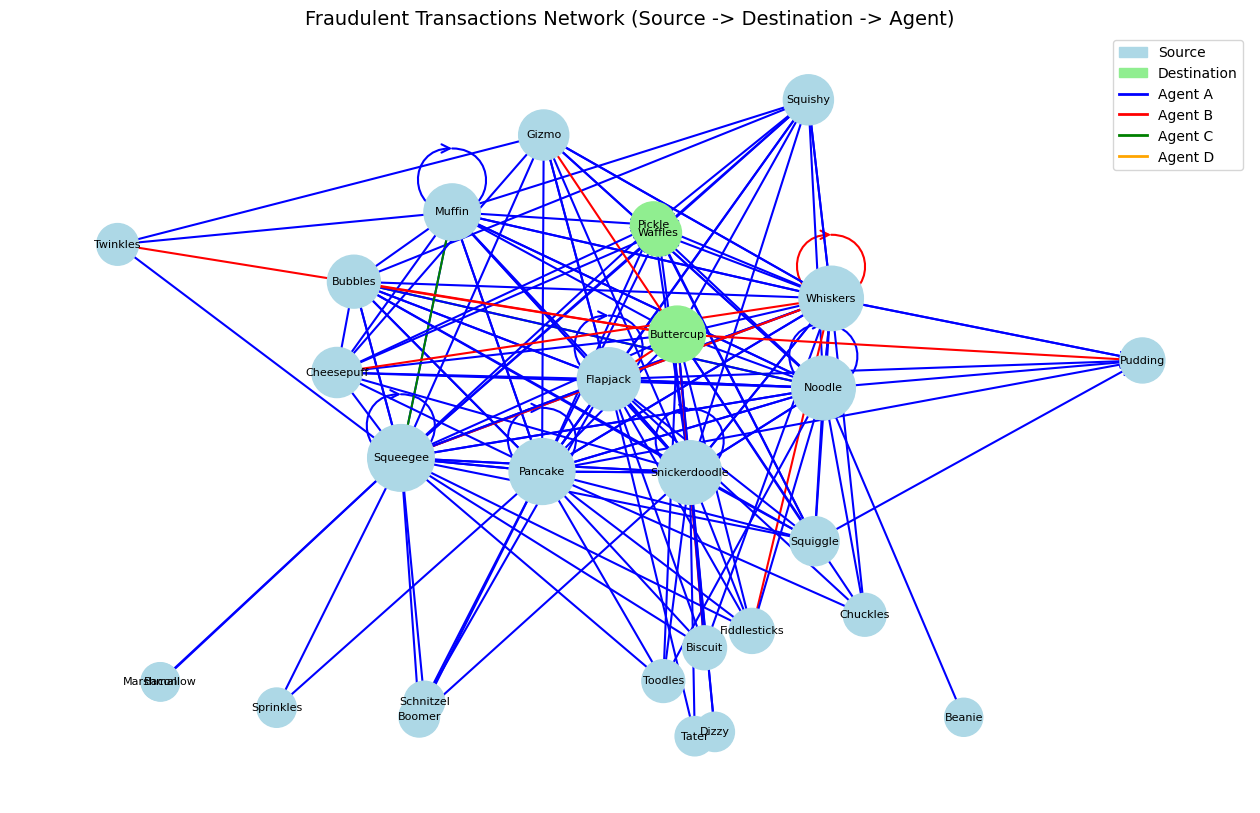

In [ ]:
fraud_data = data[data['label'] == 1].copy()

# Initialize the graph
G = nx.DiGraph()

# Add edges to the graph (source -> destination with agent as an attribute)
for index, row in fraud_data.iterrows():
    G.add_edge(row['source_prefix'], row['dest_prefix'], agent=row['agent'])


plt.figure(figsize=(16, 10))

# Re-add missing source nodes to ensure all sources are included
for source in fraud_data['source_prefix'].unique():
    if source not in G:
        G.add_node(source)

# Use a layout with better spacing
pos = nx.kamada_kawai_layout(G)

# Draw nodes with sizes based on degree
node_sizes = [700 + 50 * G.degree(node) for node in G.nodes]
node_colors = ["lightblue" if node in fraud_data['source_prefix'].unique() else "lightgreen" for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

# Draw edges with colors based on agent type
edge_colors = []
for u, v, edge_data in G.edges(data=True):
    if edge_data['agent'] == 'A':
        edge_colors.append('blue')
    elif edge_data['agent'] == 'B':
        edge_colors.append('red')
    elif edge_data['agent'] == 'C':
        edge_colors.append('green')
    else:
        edge_colors.append('gray')  # Default color for unknown agents

# Draw the edges with colored arrows
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color=edge_colors, width=1.5)

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

# Add a legend to explain node types and edge colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

node_legend = [
    mpatches.Patch(color="lightblue", label="Source"),
    mpatches.Patch(color="lightgreen", label="Destination")
]
edge_legend = [
    Line2D([0], [0], color="blue", lw=2, label="Agent A"),
    Line2D([0], [0], color="red", lw=2, label="Agent B"),
    Line2D([0], [0], color="green", lw=2, label="Agent C"),
    Line2D([0], [0], color="orange", lw=2, label="Agent D")
]

plt.legend(handles=node_legend + edge_legend, loc="best", fontsize=10)

plt.title("Fraudulent Transactions Network (Source -> Destination -> Agent)", fontsize=14)
plt.axis("off")
plt.show()




Note: some nodes are both source and dest but their colors indicate they were mostly appear as each of them

In [ ]:
# check for self-loops in the dataset
self_loops = data[data['source_prefix'] == data['dest_prefix']]


total_self_loops = len(self_loops)


fraudulent_self_loops = len(self_loops[self_loops['label'] == 1])


fraudulent_self_loops_percentage = (fraudulent_self_loops / total_self_loops) * 100 if total_self_loops > 0 else 0

{
    "Total Self-Loops": total_self_loops,
    "Fraudulent Self-Loops": fraudulent_self_loops,
    "Percentage of Fraudulent Self-Loops": round(fraudulent_self_loops_percentage, 2)
}


{'Total Self-Loops': 13563,
 'Fraudulent Self-Loops': 129,
 'Percentage of Fraudulent Self-Loops': 0.95}

This means that less than 1% of transactions with the same source and destination are fraudulent. so self loops cant be a good feature.

#11.Top 10s in fraud

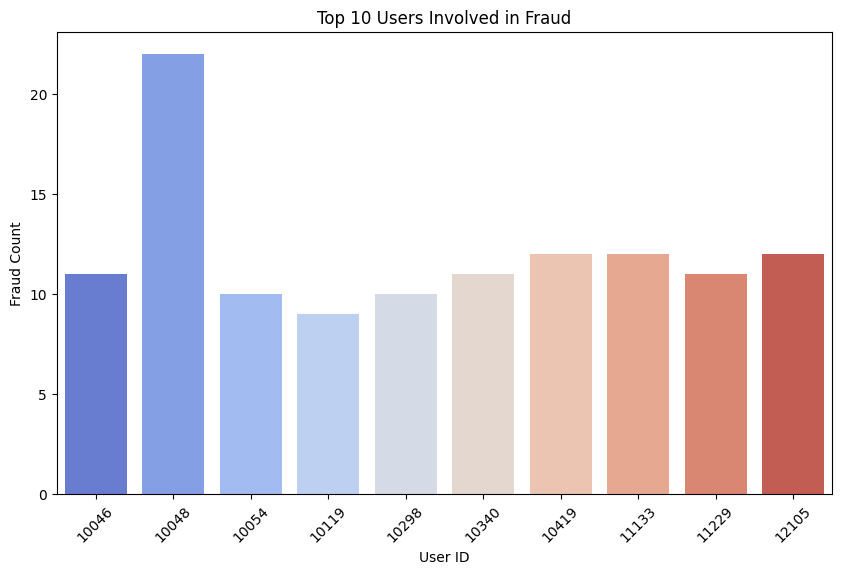

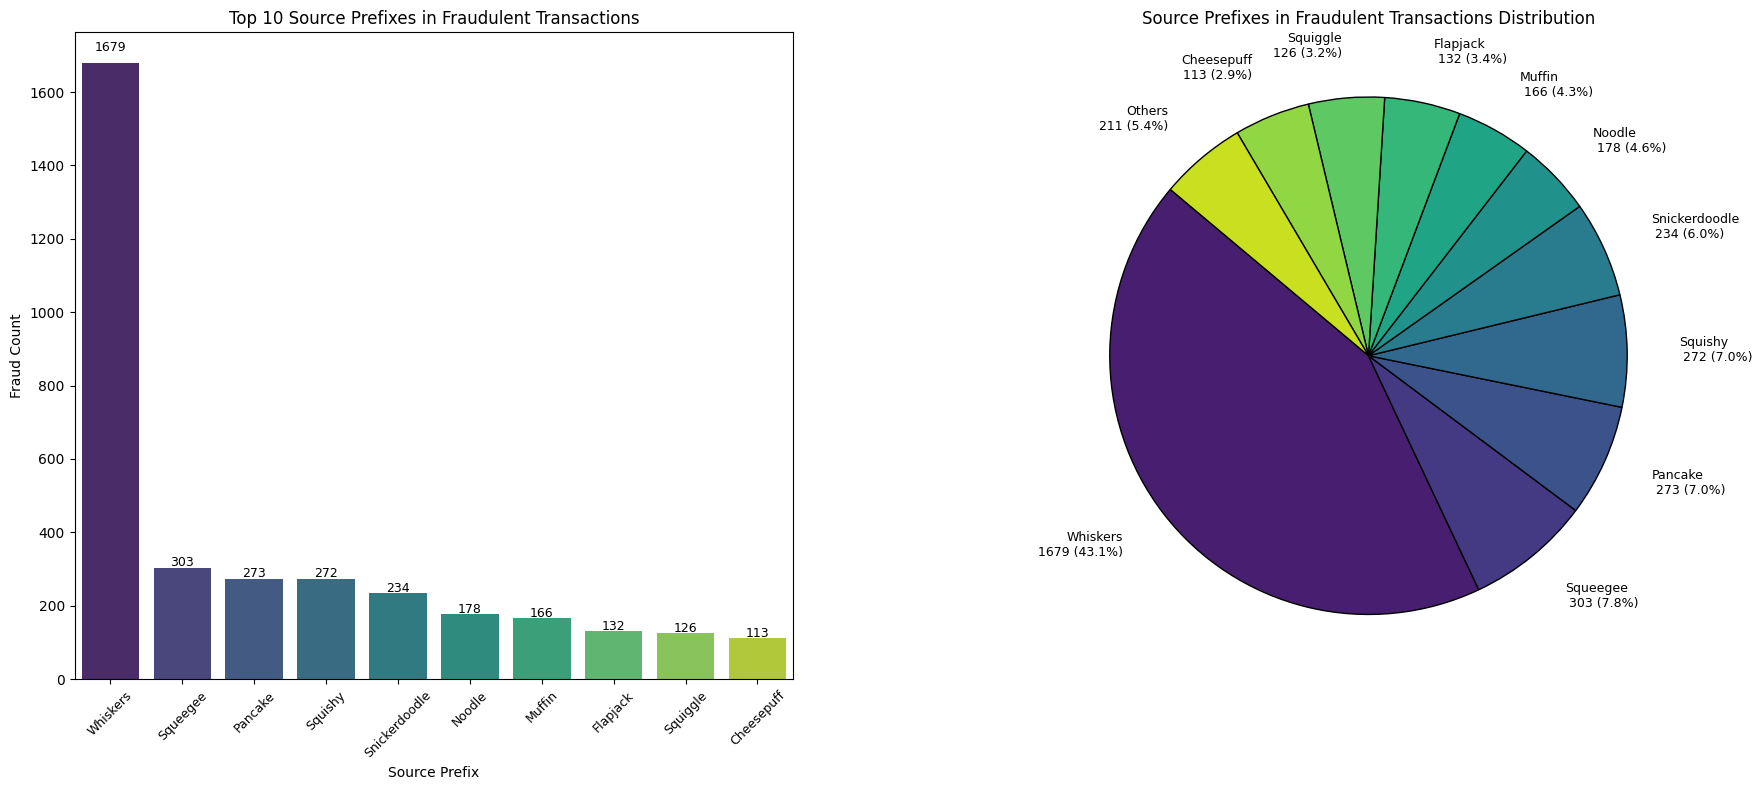

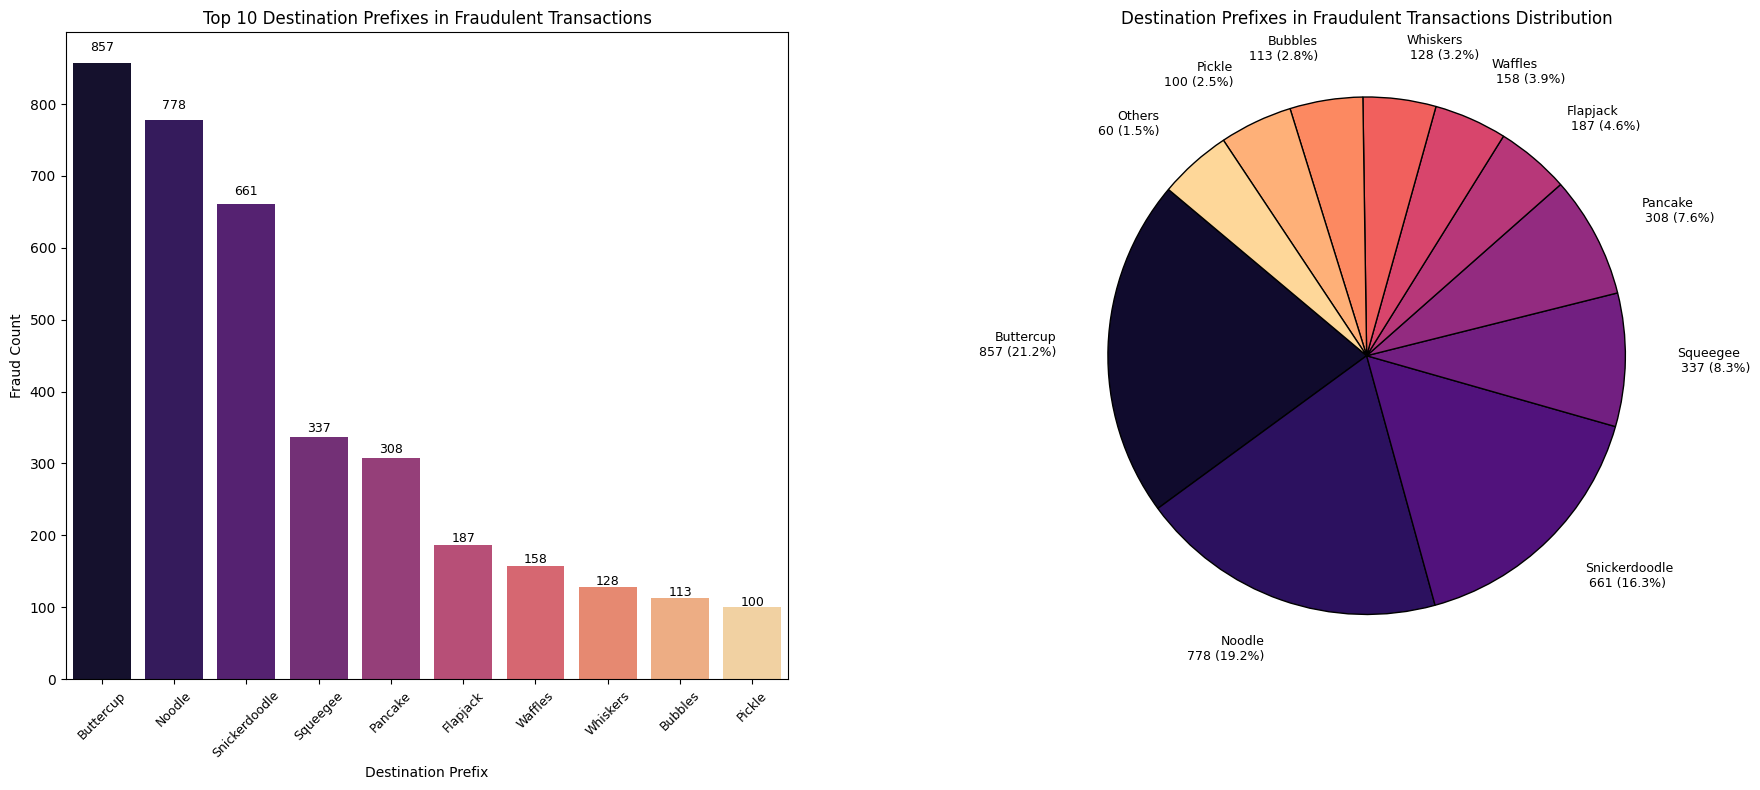

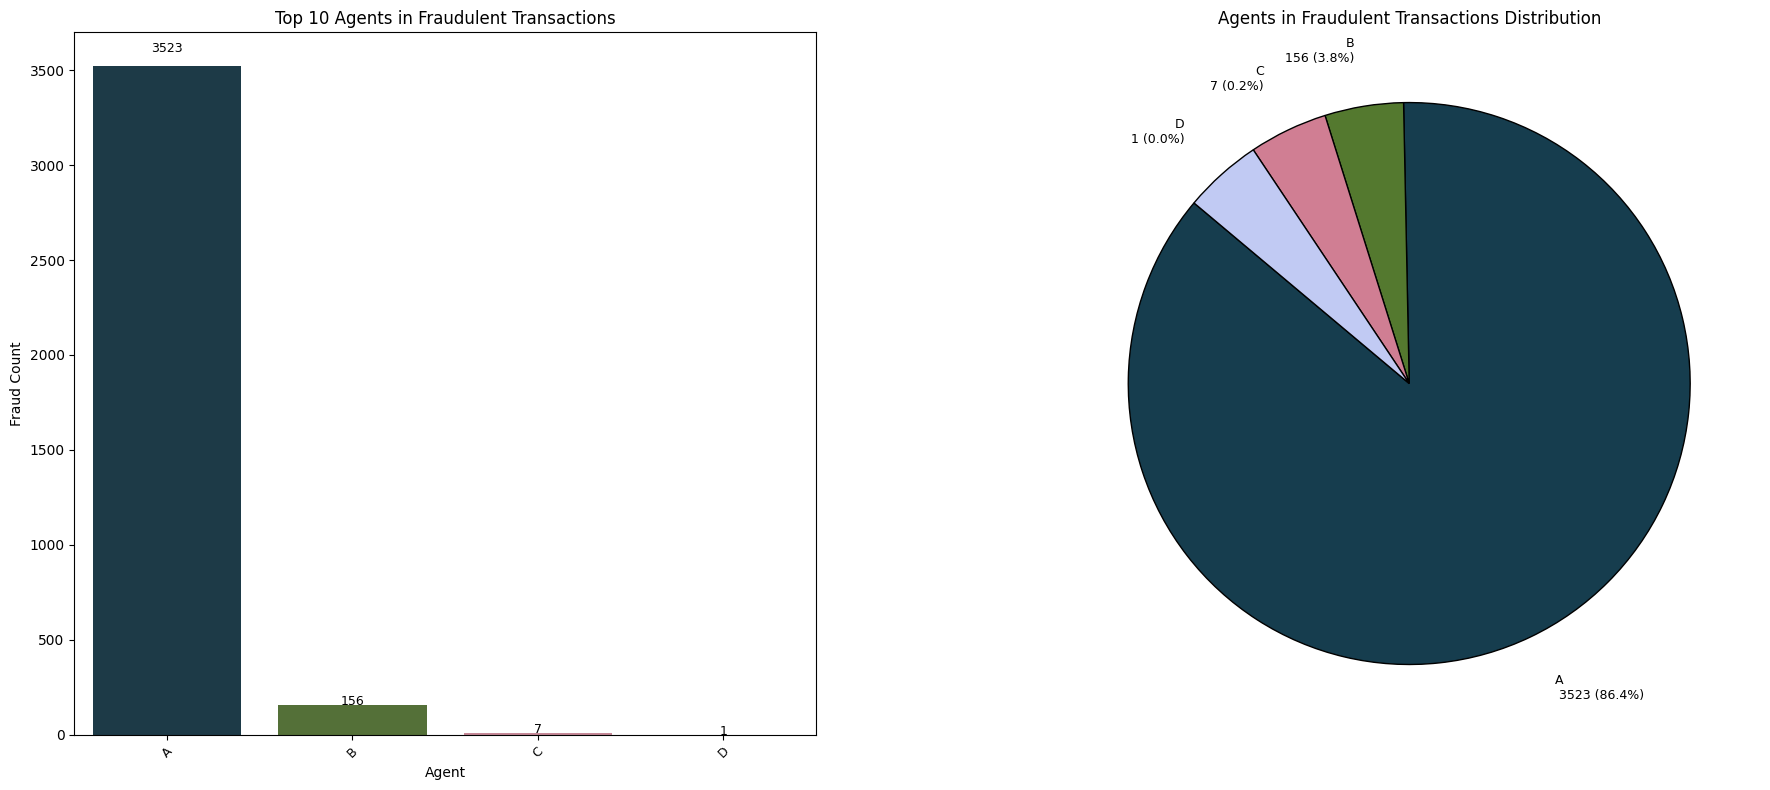

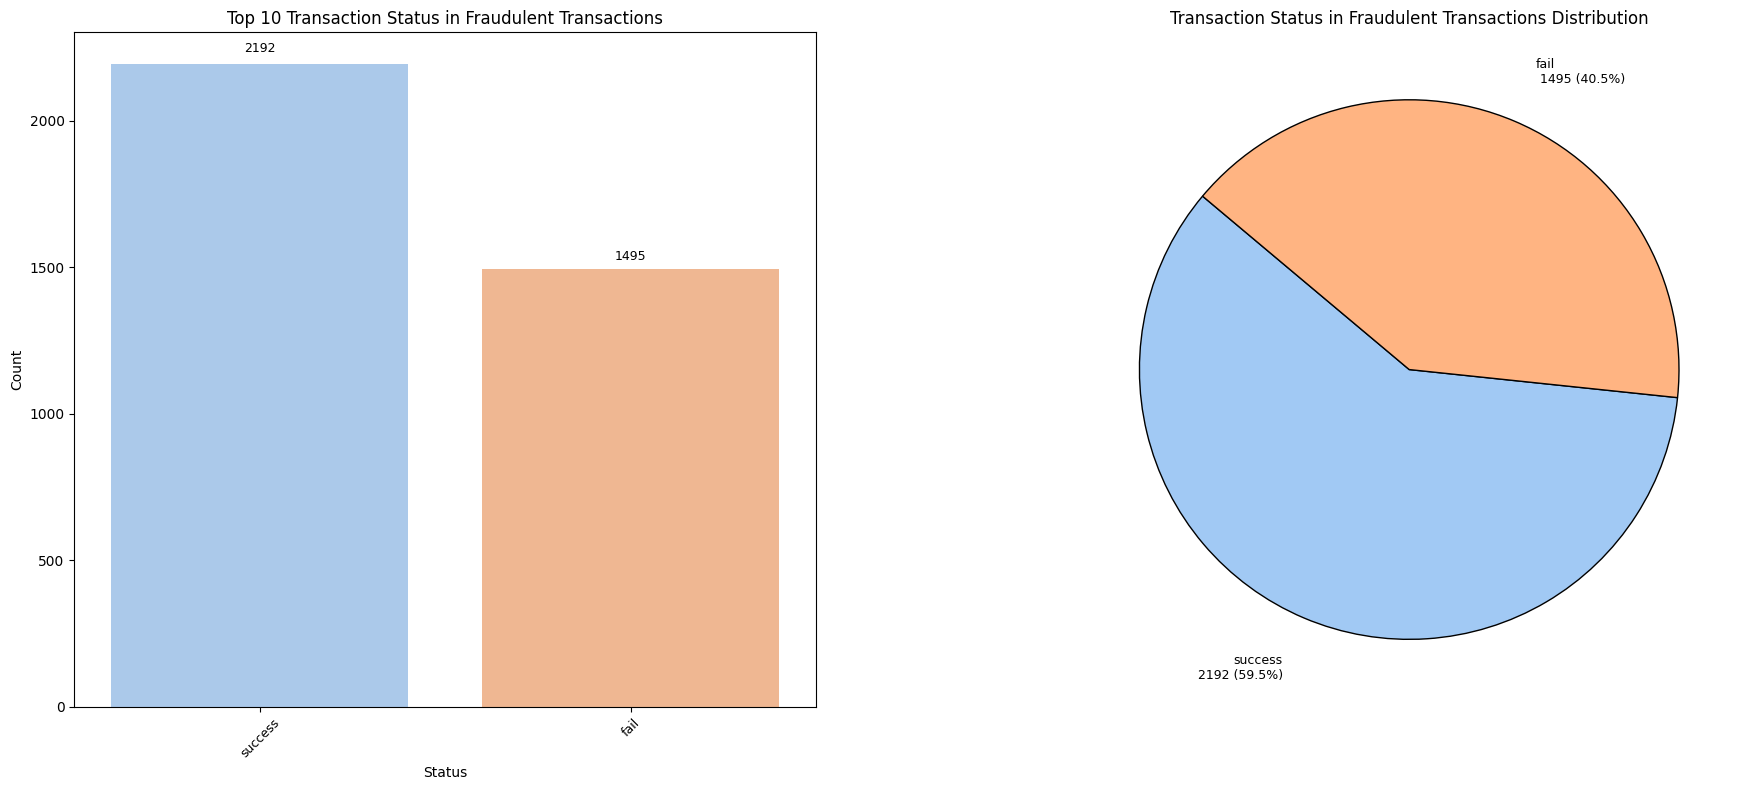

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=fraud_data['user'].value_counts().head(10).index,
            y=fraud_data['user'].value_counts().head(10).values,
            palette='coolwarm', ax=ax)

ax.set_title('Top 10 Users Involved in Fraud')
ax.set_xlabel('User ID')
ax.set_ylabel('Fraud Count')
ax.tick_params(axis='x', rotation=45)

plt.show()


def scaled_with_real_numbers_bar_and_pie(data, title, xlabel, ylabel, labels_title, colors_palette):
    plt.figure(figsize=(18, 8))

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(x=data.index, y=data.values, palette=colors_palette)
    plt.title(f'Top 10 {title}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, fontsize=9)


    for idx, value in enumerate(data.values):
        plt.text(idx, value + (value * 0.02), str(value), ha='center', fontsize=9, color='black')

    # Pie chart
    plt.subplot(1, 2, 2)
    total_counts = fraud_data[labels_title].value_counts()

    if len(total_counts) > 10:  # Check if "Others" is needed
        others_count = total_counts[10:].sum()
        sizes = data.tolist() + [others_count]
        labels = data.index.tolist() + ['Others']
    else:
        sizes = data.tolist()
        labels = data.index.tolist()


    min_visible_fraction = 0.05
    scaled_sizes = [max(size, min_visible_fraction * sum(sizes)) for size in sizes]
    total_scaled = sum(scaled_sizes)
    scaled_labels = [f"{label}\n {int(size)} ({size / total_scaled:.1%})" for label, size in zip(labels, sizes)]

    plt.pie(
        scaled_sizes,
        labels=scaled_labels,
        startangle=140,
        colors=sns.color_palette(colors_palette, len(scaled_sizes)),
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        textprops={'fontsize': 9},
        labeldistance=1.2
    )

    plt.title(f'{title} Distribution')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()


# Source prefixes commonly associated with fraud
fraud_sources = fraud_data['source_prefix'].value_counts().head(10)
scaled_with_real_numbers_bar_and_pie(fraud_sources, "Source Prefixes in Fraudulent Transactions", "Source Prefix", "Fraud Count", "source_prefix", "viridis")

# Destination prefixes commonly associated with fraud
fraud_destinations = fraud_data['dest_prefix'].value_counts().head(10)
scaled_with_real_numbers_bar_and_pie(fraud_destinations, "Destination Prefixes in Fraudulent Transactions", "Destination Prefix", "Fraud Count", "dest_prefix", "magma")

# Agent usage in fraudulent transactions
fraud_agents = fraud_data['agent'].value_counts().head(10)
scaled_with_real_numbers_bar_and_pie(fraud_agents, "Agents in Fraudulent Transactions", "Agent", "Fraud Count", "agent", "cubehelix")

# Transaction status distribution in fraud cases
fraud_status = fraud_data['status'].value_counts()
scaled_with_real_numbers_bar_and_pie(fraud_status, "Transaction Status in Fraudulent Transactions", "Status", "Count", "status", "pastel")


1. **Top Users Involved in Fraud:**
   - Certain users, such as user `10048`, have consistently high fraud counts, indicating the presence of repeat offenders. This suggest tracking user behavior in models.

2. **Source Prefixes in Fraudulent Transactions:**
   - The prefix `Whiskers` is disproportionately associated with fraudulent transactions, accounting for 43.1% of cases.
   - Other prefixes, such as `Squeegee`, `Pancake`, and `Squishy`, also contribute significantly, indicating that multiple prefixes are involved in fraudulent activities.

3. **Destination Prefixes in Fraudulent Transactions:**
   - The destination prefix `Buttercup` is the most common among fraud cases, representing 21.2% of fraudulent transactions.
   - `Noodle` and `Snickerdoodle` are also notable, suggesting that specific destinations are frequently targeted.

4. **Agents in Fraudulent Transactions:**
   - Agent `A` is associated with 86.4% of fraudulent transactions, dominating all other agents.


5. **Transaction Status in Fraudulent Transactions:**
   - Both successful (59.5%) and failed (40.5%) transactions occur frequently in fraudulent cases.
   - This balance indicates that transaction status alone is not a strong predictor of fraud.

---

### Recommendations for Modeling:

1. **Feature Engineering:**
   - **User Features:** Creating a feature to identify repeat offenders by analyzing user transaction history.
   - **Prefix Features:** Include categorical features for high-risk source prefixes (`Whiskers`, `Squeegee`) and destination prefixes (`Buttercup`, `Noodle`).
   - **Agent Features:** Add agent data as a categorical feature, emphasizing transactions involving agent `A`.









#خلاصه کلی تسک اول (استخراج دیتا)

به طور کلی میشه از نمودار ها نتیجه گرفت که مهم ترین فیچر ها در تشخیص تقلب ، فیچر هایی هستند که مسیر تراکنش رو شکل میدن، شامل یوزر،مبدا، مقصد، ایجنت ، همچنین ساعت هایی از روز مثل ۱۸ تا ۲۲ شب رو هم میتونیم به عنوان یه فیچر تاثیر گزار داشته باشیم(در دیتا های زمانی سال یکسان بود برا همه همچنین روز های هفته و روز های ما پترن خاصی نداشتن)

من در یادگیری باناظر از ترکیب این فیچر ها و حالات خاص اتفاق افتادنشون و در تسک های بعدی از حالت دیفالتشون استفاده کردم(دلیل استفاده از حالت دیفالت این است که
فیچر ها با توجه به لیبل تنظیم نشده باشن و مدل بیشتر آن سوپروایز باشه)

توجه:  توضیحات مربوط به مدل هارو در آخرین سل انجام دادم

# **Supervised Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
!pip install  tab-transformer-pytorch

##Using transformers (without oversampling)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tab_transformer_pytorch import TabTransformer
from tqdm import tqdm

# Load the dataset
file_path = '/content/drive/MyDrive/data_for_interview.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Convert `date` to datetime
data['date'] = pd.to_datetime(data['date'], unit='ms')

# Feature Engineering
data['hour'] = data['date'].dt.hour
data['is_night_high_risk'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Fraud rates for `source_prefix` and `dest_prefix` combinations
source_dest_fraud_rate = data.groupby(['source_prefix', 'dest_prefix'])['label'].mean().reset_index()
source_dest_fraud_rate.rename(columns={'label': 'source_dest_fraud_rate'}, inplace=True)
data = data.merge(source_dest_fraud_rate, on=['source_prefix', 'dest_prefix'], how='left')

# Binary flag for high-risk source-destination pairs
high_risk_threshold = 0.5
data['is_high_risk_pair'] = (data['source_dest_fraud_rate'] > high_risk_threshold).astype(int)

# User-level aggregations
user_behavior = data.groupby('user').agg(
    total_transactions=('label', 'count'),
    fraud_count=('label', 'sum')
).reset_index()
user_behavior['fraud_rate'] = user_behavior['fraud_count'] / user_behavior['total_transactions']
user_behavior['is_high_risk_user'] = (user_behavior['fraud_count'] > 5).astype(int)
data = data.merge(user_behavior, on='user', how='left')

# Fraud rates for source and destination
source_fraud_rate = data.groupby('source_prefix')['label'].mean().reset_index()
source_fraud_rate.rename(columns={'label': 'source_fraud_rate'}, inplace=True)
dest_fraud_rate = data.groupby('dest_prefix')['label'].mean().reset_index()
dest_fraud_rate.rename(columns={'label': 'dest_fraud_rate'}, inplace=True)
data = data.merge(source_fraud_rate, on='source_prefix', how='left')
data = data.merge(dest_fraud_rate, on='dest_prefix', how='left')

# Retain engineered features
important_features = [
    'source_prefix', 'dest_prefix', 'agent',
    'hour', 'is_night_high_risk',
    'total_transactions', 'fraud_count', 'fraud_rate',
    'source_fraud_rate', 'dest_fraud_rate',
    'source_dest_fraud_rate', 'is_high_risk_pair',
    'is_high_risk_user'
]

X = data[important_features]
y = data['label']

# Encode categorical columns
categorical_features = ['source_prefix', 'dest_prefix', 'agent']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Separate categorical and continuous features
continuous_features = [col for col in X.columns if col not in categorical_features]

# Normalize continuous features
scaler = MinMaxScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

# Convert features into numpy arrays
X_cat = X[categorical_features].values
X_cont = X[continuous_features].values

# Split into train and test sets
X_cat_train, X_cat_test, X_cont_train, X_cont_test, y_train, y_test = train_test_split(
    X_cat, X_cont, y, test_size=0.2, random_state=42, stratify=y
)

# Define PyTorch Dataset
class TabularDataset(Dataset):
    def __init__(self, X_cat, X_cont, y):
        self.X_cat = X_cat
        self.X_cont = X_cont
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X_cat[idx], dtype=torch.long),  # Categorical data
            torch.tensor(self.X_cont[idx], dtype=torch.float32),  # Continuous data
            torch.tensor(self.y.iloc[idx], dtype=torch.long)  # Labels
        )

# Create DataLoaders
train_dataset = TabularDataset(X_cat_train, X_cont_train, pd.Series(y_train))
test_dataset = TabularDataset(X_cat_test, X_cont_test, pd.Series(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the TabTransformer model
model = TabTransformer(
    categories=[len(np.unique(X[col])) for col in categorical_features],
    num_continuous=len(continuous_features),
    dim=32,
    dim_out=2,  # Output logits for two classes
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler to change learning rate after 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Training loop
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Training the TabTransformer model...")
for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    for X_cat_batch, X_cont_batch, y_batch in train_loader:
        X_cat_batch, X_cont_batch, y_batch = (
            X_cat_batch.to(device),
            X_cont_batch.to(device),
            y_batch.to(device),
        )
        optimizer.zero_grad()
        preds = model(X_cat_batch, X_cont_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation phase
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for X_cat_batch, X_cont_batch, y_batch in test_loader:
            X_cat_batch, X_cont_batch, y_batch = (
                X_cat_batch.to(device),
                X_cont_batch.to(device),
                y_batch.to(device),
            )
            preds = model(X_cat_batch, X_cont_batch).argmax(dim=1)
            y_val_true.extend(y_batch.cpu().numpy())
            y_val_pred.extend(preds.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = (np.array(y_val_true) == np.array(y_val_pred)).mean()

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]}, Validation Accuracy: {val_accuracy:.4f}")

# Final evaluation on test data
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, y_batch in test_loader:
        X_cat_batch, X_cont_batch, y_batch = (
            X_cat_batch.to(device),
            X_cont_batch.to(device),
            y_batch.to(device),
        )
        preds = model(X_cat_batch, X_cont_batch).argmax(dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report and Confusion Matrix
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Training the TabTransformer model...
Epoch 1/30, Loss: 46.1135, LR: 0.001, Validation Accuracy: 0.9892
Epoch 2/30, Loss: 33.1109, LR: 0.001, Validation Accuracy: 0.9905
Epoch 3/30, Loss: 31.0339, LR: 0.001, Validation Accuracy: 0.9875
Epoch 4/30, Loss: 30.2728, LR: 0.001, Validation Accuracy: 0.9908
Epoch 5/30, Loss: 29.4803, LR: 0.001, Validation Accuracy: 0.9902
Epoch 6/30, Loss: 28.4417, LR: 0.001, Validation Accuracy: 0.9908
Epoch 7/30, Loss: 27.4475, LR: 0.001, Validation Accuracy: 0.9904
Epoch 8/30, Loss: 27.2426, LR: 0.001, Validation Accuracy: 0.9906
Epoch 9/30, Loss: 26.5561, LR: 0.001, Validation Accuracy: 0.9904
Epoch 10/30, Loss: 26.5752, LR: 0.001, Validation Accuracy: 0.9905
Epoch 11/30, Loss: 26.0006, LR: 0.001, Validation Accuracy: 0.9903
Epoch 12/30, Loss: 25.5522, LR: 0.001, Validation Accuracy: 0.9910
Epoch 13/30, Loss: 25.4625, LR: 0.001, Validation Accuracy: 0.9902
Epoch 14/30, Loss: 24.8426, LR: 0.001, Validation Accuracy: 0.9904
Epoch 15/30, Loss: 24.8096, LR: 0.

## 1.1feature engenerring Using Oversampling

Epoch 1/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9519 - loss: 0.1290 - val_accuracy: 0.9993 - val_loss: 0.0283
Epoch 2/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9837 - loss: 0.0496 - val_accuracy: 0.9992 - val_loss: 0.0322
Epoch 3/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9840 - loss: 0.0480 - val_accuracy: 0.9955 - val_loss: 0.0435
Epoch 4/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9844 - loss: 0.0468 - val_accuracy: 0.9998 - val_loss: 0.0288
Epoch 5/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9838 - loss: 0.0464 - val_accuracy: 0.9991 - val_loss: 0.0270
Epoch 6/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9858 - loss: 0.0429 - val_accuracy: 0.9976 - val_loss: 0.0232
Epoch 7/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9863 - loss: 0.0412 - val_accuracy: 0.9995 - val_loss: 0.0345
Epoch 8/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9867 - loss: 0.0402 -

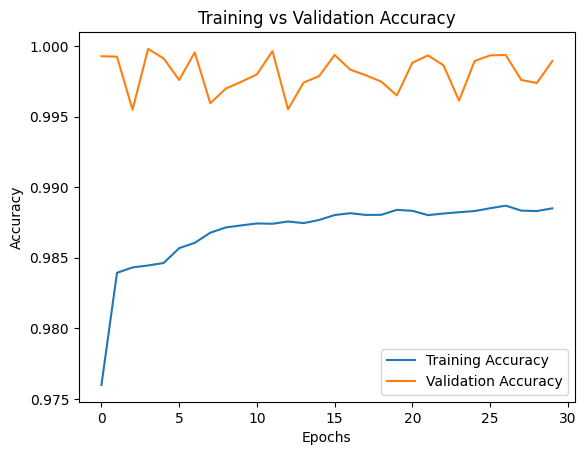

Test Accuracy: 0.9841
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     20471
           1       0.69      0.98      0.81       737

    accuracy                           0.98     21208
   macro avg       0.85      0.98      0.90     21208
weighted avg       0.99      0.98      0.99     21208

Confusion Matrix:
 [[20147   324]
 [   13   724]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


file_path = '/content/drive/MyDrive/data_for_interview.csv'  # Replace with your file path
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'], unit='ms')

data['hour'] = data['date'].dt.hour
data['is_night_high_risk'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

source_dest_fraud_rate = data.groupby(['source_prefix', 'dest_prefix'])['label'].mean().reset_index()
source_dest_fraud_rate.rename(columns={'label': 'source_dest_fraud_rate'}, inplace=True)
data = data.merge(source_dest_fraud_rate, on=['source_prefix', 'dest_prefix'], how='left')


high_risk_threshold = 0.5
data['is_high_risk_pair'] = (data['source_dest_fraud_rate'] > high_risk_threshold).astype(int)

user_behavior = data.groupby('user').agg(
    total_transactions=('label', 'count'),
    fraud_count=('label', 'sum')
).reset_index()


user_behavior['fraud_rate'] = user_behavior['fraud_count'] / user_behavior['total_transactions']

user_behavior['is_high_risk_user'] = (user_behavior['fraud_count'] > 5).astype(int)

data = data.merge(user_behavior, on='user', how='left')


source_fraud_rate = data.groupby('source_prefix')['label'].mean().reset_index()
source_fraud_rate.rename(columns={'label': 'source_fraud_rate'}, inplace=True)

dest_fraud_rate = data.groupby('dest_prefix')['label'].mean().reset_index()
dest_fraud_rate.rename(columns={'label': 'dest_fraud_rate'}, inplace=True)

data = data.merge(source_fraud_rate, on='source_prefix', how='left')
data = data.merge(dest_fraud_rate, on='dest_prefix', how='left')


high_risk_sources = ['Whiskers', 'Squeegee', 'Pancake', 'Squishy', 'Snickerdoodle']
high_risk_destinations = ['Buttercup', 'Noodle', 'Snickerdoodle', 'Squeegee', 'Pancake']


data['is_high_risk_source'] = data['source_prefix'].apply(lambda x: 1 if x in high_risk_sources else 0)
data['is_high_risk_dest'] = data['dest_prefix'].apply(lambda x: 1 if x in high_risk_destinations else 0)


source_fraud_proportion = data.groupby('source_prefix')['label'].mean().reset_index()
source_fraud_proportion.rename(columns={'label': 'source_fraud_score'}, inplace=True)

dest_fraud_proportion = data.groupby('dest_prefix')['label'].mean().reset_index()
dest_fraud_proportion.rename(columns={'label': 'dest_fraud_score'}, inplace=True)


data = data.merge(source_fraud_proportion, on='source_prefix', how='left')
data = data.merge(dest_fraud_proportion, on='dest_prefix', how='left')


important_features = [
    'source_prefix', 'dest_prefix', 'agent',
    'hour', 'is_night_high_risk',
    'total_transactions', 'fraud_count',
    'fraud_rate',
    'source_fraud_rate', 'dest_fraud_rate',
    'source_dest_fraud_rate', 'is_high_risk_pair',
    'is_high_risk_source', 'is_high_risk_dest',
    'source_fraud_score', 'dest_fraud_score'
]

X = data[important_features]
y = data['label']


label_encoders = {}
for col in ['source_prefix', 'dest_prefix', 'agent']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE for oversampling to the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


model = Sequential([
    Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred_probs = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


##1.2 feature engenerring without Using Oversampling

Epoch 1/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9552 - loss: 0.1163 - val_accuracy: 0.9879 - val_loss: 0.0293
Epoch 2/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9881 - loss: 0.0295 - val_accuracy: 0.9889 - val_loss: 0.0261
Epoch 3/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9898 - loss: 0.0247 - val_accuracy: 0.9886 - val_loss: 0.0250
Epoch 4/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9890 - loss: 0.0249 - val_accuracy: 0.9886 - val_loss: 0.0239
Epoch 5/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9893 - loss: 0.0238 - val_accuracy: 0.9885 - val_loss: 0.0237
Epoch 6/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9900 - loss: 0.0221 - val_accuracy: 0.9882 - val_loss: 0.0230
Epoch 7/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9902 - loss: 0.0222 - val_accuracy: 0.9890 - val_loss: 0.0230
Epoch 8/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9901 - loss: 0.0222 - 

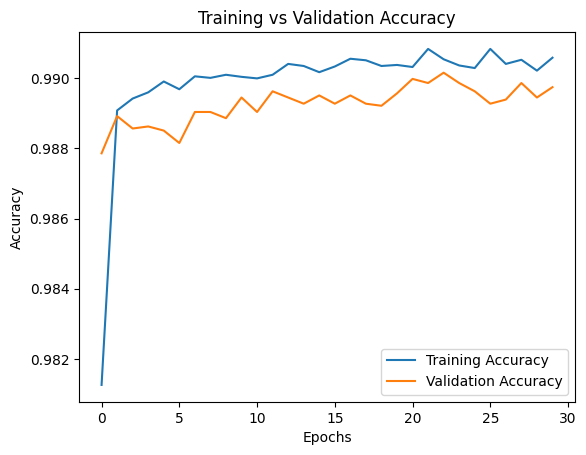

Test Accuracy: 0.9909
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20471
           1       0.87      0.87      0.87       737

    accuracy                           0.99     21208
   macro avg       0.93      0.93      0.93     21208
weighted avg       0.99      0.99      0.99     21208

Confusion Matrix:
 [[20372    99]
 [   95   642]]


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = '/content/drive/MyDrive/data_for_interview.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Convert `date` to datetime
data['date'] = pd.to_datetime(data['date'], unit='ms')

# Extract time-based features
data['hour'] = data['date'].dt.hour
data['is_night_high_risk'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Fraud rates for `source_prefix` and `dest_prefix` combinations
source_dest_fraud_rate = data.groupby(['source_prefix', 'dest_prefix'])['label'].mean().reset_index()
source_dest_fraud_rate.rename(columns={'label': 'source_dest_fraud_rate'}, inplace=True)
data = data.merge(source_dest_fraud_rate, on=['source_prefix', 'dest_prefix'], how='left')

# Binary flag for high-risk source-destination pairs
high_risk_threshold = 0.5  # Define a threshold for high fraud rates
data['is_high_risk_pair'] = (data['source_dest_fraud_rate'] > high_risk_threshold).astype(int)

# User-level aggregations
user_behavior = data.groupby('user').agg(
    total_transactions=('label', 'count'),
    fraud_count=('label', 'sum')
).reset_index()

# Fraud rate per user
user_behavior['fraud_rate'] = user_behavior['fraud_count'] / user_behavior['total_transactions']

# High-risk user indicator
user_behavior['is_high_risk_user'] = (user_behavior['fraud_count'] > 5).astype(int)

# Merge user behavior features back into the main dataset
data = data.merge(user_behavior, on='user', how='left')

# Fraud rates for source and destination
source_fraud_rate = data.groupby('source_prefix')['label'].mean().reset_index()
source_fraud_rate.rename(columns={'label': 'source_fraud_rate'}, inplace=True)

dest_fraud_rate = data.groupby('dest_prefix')['label'].mean().reset_index()
dest_fraud_rate.rename(columns={'label': 'dest_fraud_rate'}, inplace=True)

data = data.merge(source_fraud_rate, on='source_prefix', how='left')
data = data.merge(dest_fraud_rate, on='dest_prefix', how='left')

# Add high-risk source and destination flags based on observed proportions
high_risk_sources = ['Whiskers', 'Squeegee', 'Pancake', 'Squishy', 'Snickerdoodle']
high_risk_destinations = ['Buttercup', 'Noodle', 'Snickerdoodle', 'Squeegee', 'Pancake']

# Create binary features for high-risk source and destination prefixes
data['is_high_risk_source'] = data['source_prefix'].apply(lambda x: 1 if x in high_risk_sources else 0)
data['is_high_risk_dest'] = data['dest_prefix'].apply(lambda x: 1 if x in high_risk_destinations else 0)

# Calculate fraud proportions for each source and destination prefix
source_fraud_proportion = data.groupby('source_prefix')['label'].mean().reset_index()
source_fraud_proportion.rename(columns={'label': 'source_fraud_score'}, inplace=True)

dest_fraud_proportion = data.groupby('dest_prefix')['label'].mean().reset_index()
dest_fraud_proportion.rename(columns={'label': 'dest_fraud_score'}, inplace=True)

# Merge fraud scores into the dataset
data = data.merge(source_fraud_proportion, on='source_prefix', how='left')
data = data.merge(dest_fraud_proportion, on='dest_prefix', how='left')

# Retain important features
important_features = [
    'source_prefix', 'dest_prefix', 'agent',
    'hour', 'is_night_high_risk',
    'total_transactions', 'fraud_count',
    'fraud_rate',
    'source_fraud_rate', 'dest_fraud_rate',
    'source_dest_fraud_rate', 'is_high_risk_pair',
    'is_high_risk_source', 'is_high_risk_dest',
    'source_fraud_score', 'dest_fraud_score'
]

X = data[important_features]
y = data['label']

# Encode categorical columns
label_encoders = {}
for col in ['source_prefix', 'dest_prefix', 'agent']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Normalize numerical columns
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report and confusion matrix
y_pred_probs = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


## 2.1 Use original column with over sampling

Epoch 1/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9065 - loss: 0.2073 - val_accuracy: 0.9994 - val_loss: 0.0414
Epoch 2/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9806 - loss: 0.0697 - val_accuracy: 0.9981 - val_loss: 0.0548
Epoch 3/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9827 - loss: 0.0624 - val_accuracy: 0.9999 - val_loss: 0.0298
Epoch 4/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9828 - loss: 0.0609 - val_accuracy: 0.9998 - val_loss: 0.0251
Epoch 5/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9838 - loss: 0.0580 - val_accuracy: 0.9998 - val_loss: 0.0330
Epoch 6/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9850 - loss: 0.0553 - val_accuracy: 0.9996 - val_loss: 0.0272
Epoch 7/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9851 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.0269
Epoch 8/30
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9854 - loss: 0.0523 

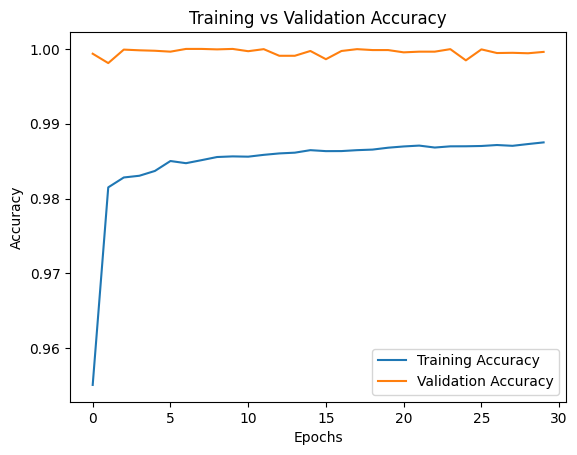

Test Accuracy: 0.9837
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     20471
           1       0.68      0.99      0.81       737

    accuracy                           0.98     21208
   macro avg       0.84      0.99      0.90     21208
weighted avg       0.99      0.98      0.99     21208

Confusion Matrix:
 [[20131   340]
 [    5   732]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


file_path = '/content/drive/MyDrive/data_for_interview.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['label'])
y = data['label']

# Encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


model = Sequential([
    Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)

# Save the weights
weights_file_path = 'supervised_model_weights_oversampled.weights.h5'  # Changed filename for oversampled model
model.save_weights(weights_file_path)
print("Model weights saved successfully.")


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred_probs = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


##  2.2 Use original column **`without`** over sampling

Epoch 1/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9629 - loss: 0.1317 - val_accuracy: 0.9705 - val_loss: 0.0527
Epoch 2/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9739 - loss: 0.0514 - val_accuracy: 0.9785 - val_loss: 0.0413
Epoch 3/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9765 - loss: 0.0441 - val_accuracy: 0.9800 - val_loss: 0.0390
Epoch 4/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9775 - loss: 0.0420 - val_accuracy: 0.9792 - val_loss: 0.0380
Epoch 5/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9803 - loss: 0.0380 - val_accuracy: 0.9808 - val_loss: 0.0371
Epoch 6/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9809 - loss: 0.0378 - val_accuracy: 0.9830 - val_loss: 0.0346
Epoch 7/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9815 - loss: 0.0373 - val_accuracy: 0.9834 - val_loss: 0.0335
Epoch 8/30
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9819 - loss: 0.0354 -

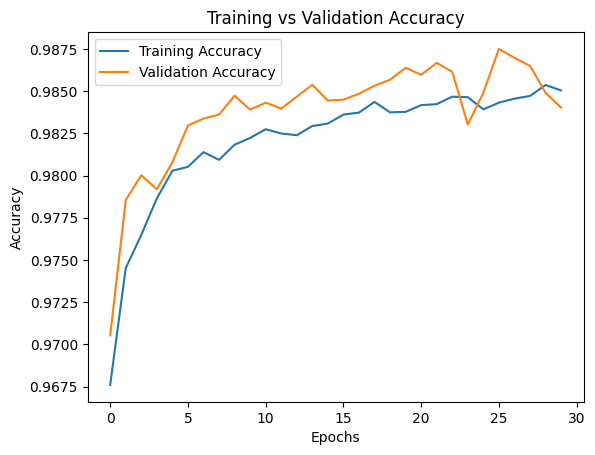

Test Accuracy: 0.9841
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     20471
           1       0.76      0.79      0.78       737

    accuracy                           0.98     21208
   macro avg       0.88      0.89      0.88     21208
weighted avg       0.98      0.98      0.98     21208

Confusion Matrix:
 [[20285   186]
 [  152   585]]


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = '/content/drive/MyDrive/data_for_interview.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Drop `label` to keep only original features
X = data.drop(columns=['label'])
y = data['label']  # Target column

# Encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Normalize numerical columns
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build the model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on original training data
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)

# Save the weights
weights_file_path = 'supervised_model_weights_no_oversample.weights.h5'  # Filename for model without oversampling
model.save_weights(weights_file_path)
print("Model weights saved successfully.")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Evaluate the model on original test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report and confusion matrix
y_pred_probs = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


#Semi-supervised Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


##Semi-supervised with graph structures (GAT and GraphSAGE)

In [ ]:
!pip install torch torchvision torch-geometric dgl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 84.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, SAGEConv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np


file_path = '/content/drive/MyDrive/data_for_interview.csv'
data = pd.read_csv(file_path)


data['hour'] = pd.to_datetime(data['date'], unit='ms').dt.hour

# Encode categorical features
encoder = LabelEncoder()
data['user_encoded'] = encoder.fit_transform(data['user'])
data['source_prefix_encoded'] = encoder.fit_transform(data['source_prefix'])
data['dest_prefix_encoded'] = encoder.fit_transform(data['dest_prefix'])
data['agent_encoded'] = encoder.fit_transform(data['agent'])


features = data[['hour', 'user_encoded', 'source_prefix_encoded', 'dest_prefix_encoded', 'agent_encoded']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#  Create Edge Index
nodes = np.unique(data[['source_prefix', 'dest_prefix']].values)
node_mapping = {node: idx for idx, node in enumerate(nodes)}

edge_index = torch.tensor(
    [[node_mapping[src], node_mapping[dst]] for src, dst in zip(data['source_prefix'], data['dest_prefix'])],
    dtype=torch.long
).t()

x = torch.tensor(features_scaled, dtype=torch.float)
y_true = torch.tensor(data['label'].values, dtype=torch.long)

# Create Labeled and Unlabeled Masks
labeled_mask = np.zeros(len(data), dtype=bool)
train_indices, _ = train_test_split(
    np.arange(len(data)), stratify=data['label'], train_size=0.15, random_state=42
)
labeled_mask[train_indices] = True
labeled_mask = torch.tensor(labeled_mask)

# Create graph data
graph_data = Data(x=x, edge_index=edge_index)

#  Weighted Loss and Hybrid Loss
factor = 2.0  # Adjust this factor to prioritize fraud more heavily
class_weights = torch.tensor([1.0, len(data[data['label'] == 0]) / len(data[data['label'] == 1]) * factor], dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def hybrid_loss(out, z, edge_index, y_true, labeled_mask, alpha=0.7):
    # Classification loss on labeled nodes
    class_loss = criterion(out[labeled_mask], y_true[labeled_mask])
    # Reconstruction loss for embeddings
    recon_loss = ((z[edge_index[0]] - z[edge_index[1]])**2).mean()
    return alpha * class_loss + (1 - alpha) * recon_loss

#  GAT Model
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.6, train=self.training)
        z = self.conv2(x, edge_index)
        return torch.log_softmax(z, dim=1), z  # Return predictions and embeddings

#  GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, p=0.5, train=self.training)
        z = self.conv2(x, edge_index)
        return torch.log_softmax(z, dim=1), z  # Return predictions and embeddings

#  Train and Evaluate
def train_and_evaluate(model, graph_data, labeled_mask, y_true, optimizer, epochs=200, threshold=0.7):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out, z = model(graph_data.x, graph_data.edge_index)
        loss = hybrid_loss(out, z, graph_data.edge_index, y_true, labeled_mask)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Evaluation
    model.eval()
    with torch.no_grad():
        out, _ = model(graph_data.x, graph_data.edge_index)
        probabilities = torch.exp(out[:, 1])  # Probability for fraud class
        y_pred = (probabilities > threshold).long()


    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    report = classification_report(y_true, y_pred, target_names=["Normal", "Fraud"])
    print("\nClassification Report:")
    print(report)

#  Train and Evaluate GAT with Hybrid Loss
gat_model = GAT(input_dim=x.size(1), hidden_dim=16, output_dim=2)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

print("\nTraining GAT Model with Hybrid Loss...")
train_and_evaluate(gat_model, graph_data, labeled_mask, y_true, gat_optimizer)

#  Train and Evaluate GraphSAGE with Hybrid Loss
sage_model = GraphSAGE(input_dim=x.size(1), hidden_dim=16, output_dim=2)
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.005, weight_decay=5e-4)

print("\nTraining GraphSAGE Model with Hybrid Loss...")
train_and_evaluate(sage_model, graph_data, labeled_mask, y_true, sage_optimizer)



Training GAT Model with Hybrid Loss...
Epoch 0, Loss: 0.6052975654602051
Epoch 20, Loss: 0.37474268674850464
Epoch 40, Loss: 0.35315558314323425
Epoch 60, Loss: 0.33007097244262695
Epoch 80, Loss: 0.3283326327800751
Epoch 100, Loss: 0.3225019872188568
Epoch 120, Loss: 0.31855714321136475
Epoch 140, Loss: 0.30942869186401367
Epoch 160, Loss: 0.31500479578971863
Epoch 180, Loss: 0.3136623203754425

Confusion Matrix:
[[98770  3579]
 [  351  3336]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98    102349
       Fraud       0.48      0.90      0.63      3687

    accuracy                           0.96    106036
   macro avg       0.74      0.93      0.80    106036
weighted avg       0.98      0.96      0.97    106036


Training GraphSAGE Model with Hybrid Loss...
Epoch 0, Loss: 0.6766064763069153
Epoch 20, Loss: 0.3889121115207672
Epoch 40, Loss: 0.30831629037857056
Epoch 60, Loss: 0.2595987319946289
Epoch 80, Los

##Semi- supervised with:
### Isolation Forest
###Autoencoders
###Local Outlier Factor
###Gaussian Mixture

In [ ]:
import torch
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


file_path = '/content/drive/MyDrive/data_for_interview.csv'
data = pd.read_csv(file_path)


data['hour'] = pd.to_datetime(data['date'], unit='ms').dt.hour


encoder = LabelEncoder()
data['user_encoded'] = encoder.fit_transform(data['user'])
data['source_prefix_encoded'] = encoder.fit_transform(data['source_prefix'])
data['dest_prefix_encoded'] = encoder.fit_transform(data['dest_prefix'])
data['agent_encoded'] = encoder.fit_transform(data['agent'])


features = data[['hour', 'user_encoded', 'source_prefix_encoded', 'dest_prefix_encoded', 'agent_encoded']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#  Split into labeled (15%) and unlabeled (85%) data
labeled_data, unlabeled_data = train_test_split(data, test_size=0.85, random_state=42, stratify=data['label'])

labeled_features = labeled_data[['hour', 'user_encoded', 'source_prefix_encoded', 'dest_prefix_encoded', 'agent_encoded']].values
labeled_scaled = scaler.transform(labeled_features)
x_labeled = torch.tensor(labeled_scaled, dtype=torch.float)
y_labeled = labeled_data['label'].values

# Step 3: Define Autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim // 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Autoencoder
autoencoder = Autoencoder(input_dim=x_labeled.size(1), hidden_dim=32)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train Autoencoder with labeled data
print("Training Autoencoder with Labeled Data...")
epochs = 100
for epoch in range(epochs):
    autoencoder.train()
    optimizer.zero_grad()
    reconstructed = autoencoder(x_labeled)
    loss = criterion(reconstructed, x_labeled)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

#  Evaluate Isolation Forest
print("Evaluating Isolation Forest...")
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(labeled_scaled)
isolation_scores = -isolation_forest.decision_function(labeled_scaled)
threshold_if = np.percentile(isolation_scores, 95)  # Top 5% as anomalies
y_pred_if = (isolation_scores > threshold_if).astype(int)


conf_matrix_if = confusion_matrix(y_labeled, y_pred_if)
print("\nConfusion Matrix - Isolation Forest:")
print(conf_matrix_if)

report_if = classification_report(y_labeled, y_pred_if, target_names=["Normal", "Fraud"])
print("\nClassification Report - Isolation Forest:")
print(report_if)

#  Evaluate Autoencoder
print("Evaluating Autoencoder...")
autoencoder.eval()
with torch.no_grad():
    reconstruction_error = torch.mean((x_labeled - autoencoder(x_labeled))**2, dim=1).numpy()

threshold_ae = np.percentile(reconstruction_error, 95)  # Top 5% as anomalies
y_pred_ae = (reconstruction_error > threshold_ae).astype(int)


conf_matrix_ae = confusion_matrix(y_labeled, y_pred_ae)
print("\nConfusion Matrix - Autoencoder:")
print(conf_matrix_ae)

report_ae = classification_report(y_labeled, y_pred_ae, target_names=["Normal", "Fraud"])
print("\nClassification Report - Autoencoder:")
print(report_ae)

#  Evaluate Local Outlier Factor
print("Evaluating Local Outlier Factor...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_scores = -lof.fit_predict(labeled_scaled)  # Higher = more anomalous

threshold_lof = np.percentile(lof_scores, 95)  # Top 5% as anomalies
y_pred_lof = (lof_scores > threshold_lof).astype(int)


conf_matrix_lof = confusion_matrix(y_labeled, y_pred_lof)
print("\nConfusion Matrix - Local Outlier Factor:")
print(conf_matrix_lof)

report_lof = classification_report(y_labeled, y_pred_lof, target_names=["Normal", "Fraud"])
print("\nClassification Report - Local Outlier Factor:")
print(report_lof)

#  Evaluate Gaussian Mixture Model
print("Evaluating Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(labeled_scaled)
gmm_scores = -gmm.score_samples(labeled_scaled)

threshold_gmm = np.percentile(gmm_scores, 95)  # Top 5% as anomalies
y_pred_gmm = (gmm_scores > threshold_gmm).astype(int)


conf_matrix_gmm = confusion_matrix(y_labeled, y_pred_gmm)
print("\nConfusion Matrix - Gaussian Mixture Model:")
print(conf_matrix_gmm)

report_gmm = classification_report(y_labeled, y_pred_gmm, target_names=["Normal", "Fraud"])
print("\nClassification Report - Gaussian Mixture Model:")
print(report_gmm)


Training Autoencoder with Labeled Data...
Epoch 0, Loss: 1.0275
Epoch 10, Loss: 0.4863
Epoch 20, Loss: 0.1009
Epoch 30, Loss: 0.0379
Epoch 40, Loss: 0.0171
Epoch 50, Loss: 0.0099
Epoch 60, Loss: 0.0063
Epoch 70, Loss: 0.0046
Epoch 80, Loss: 0.0036
Epoch 90, Loss: 0.0030
Evaluating Isolation Forest...

Confusion Matrix - Isolation Forest:
[[14584   768]
 [  525    28]]

Classification Report - Isolation Forest:
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96     15352
       Fraud       0.04      0.05      0.04       553

    accuracy                           0.92     15905
   macro avg       0.50      0.50      0.50     15905
weighted avg       0.93      0.92      0.93     15905

Evaluating Autoencoder...

Confusion Matrix - Autoencoder:
[[14582   770]
 [  527    26]]

Classification Report - Autoencoder:
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96     15352
       Fraud       0.0

#توضیحات مدل ها

### **نکته:چون در صورت مسائل تسک ها گفته شده بود دقت مد نظر نیست فقط یه حالت بیسیک و معمولی هر مدل اورده شده و فرض من بر این بود که میخواید اپروچی که استفاده میکنم رو بررسی کنید ، لذا با تیون کردن هایپرپارامتر ها قطعا میشه ریزالت های بهتری هم بدست اورد**





تسک ۲ (حالت یادگیری با ناظر):

  برای تسک با ناظر من برای مدل در یک حالت از ترنسفورمر ها و در حالت دیگه از یک شبکه عصبی ساده استفاده کردم ، در ورژن شبکه عصبی ساده، من نسخه های با و بدون اور سمپل و گزاشتم تا تفاوت رو ببینید همچنین در یک نسخه دیگه بدون مهندسی فیچر ها مدل رو ارزیابی کردم تا بتونید مقایسه کنید و ببینید مهندسی فیچر هایی که کردم باعث بالا رفتن دقت مدل (از ۷۶ به ۸۷ در پریسیشن) شده و درست بوده ( تو حالت اورسمپل تفاوتی ندارن ) در حالت های اورسمپل با استفاده ازت متد اسموت سعی شده تعداد دیتا ها برابر بشه ،
علت استفاده نکردنم از الگوریتم های خوشه بندی مثل کِی مین (انگلیسی بنویسم فرمت بهم میخوره ببخشید:)  ) این بود که دیتا های تقلب رو نمیشه به صورت دسته بندی جدا کرد همونطور که دیدید مثلا مبلغ های تراکنش ها تقریبا یکسان بود و بیشتر گراف طور باید حل کرد این مسائل رو، یا با استفاده از شبکه های عصبی برای تشخیص ارتباط پیچیده ای که بین مسیر های وجود داره
- اور سمپلینگ دقت ریکال (تشخیص تقلب ) رو بالا میبره ولی پریسیشن رو پایین میاره  ولی بدون استفاده از اورسمپل و با کار کردن روی مهندسی فیچر ها و پیدا
کردن فیچر های غنی تر همونطور که مشخصه میشه ریزالت های  بهتری  بدست اورد






تسک ۳ ( یادگیری بدون ناظر) :

من چندین روش رو برای یادگیری بدون ناظر استفاده کردم ولی فکر میکنم تقریبا امکان پذیر نیست که در حالت کاملا بدون ناظر مدل بتونه دقت خوبی  روی این نوع دیتا (تشخیص تقلب تراکنش ها ) داشته باشه ، تمام مدل هایی که در اینترنت دیدم از حالت سِمی سوپروایز استفاده میکنن و یه دید اولیه به مدل میدن که به چه روابطی میتونه توی دیتا مشکوک باشه و با وزن های دیتا های لیبل خورده توی بک پروپگیشن وزن دیتا های بدون لیبل هم تغیر میکنه که بصورت گرافی اولین بار تو مقاله گراف کانولوشنال نتورک معرفی شد،  به این صورت که بخش کوچکی از دیتا (پانزده درصد در مدل های من ) به عنوان داده لیبل دار مشخص میشه و تو حالت گرافی بقیه نود ها وزن هاشون با توجه با تغیرات وزن های نودای لیبل دار تغیر میکنه ، (گراف های همسایه رو هم و همسایه های دورتر تاثیر میزارن ) من از نوع معماری گرافی که یکیش بر پایه مکانیسم توجه و دیگری گراف سیج عه که جفتشون اینداکتیو هستن یعنی روی نود هایی که ندیدن و به ساختار گراف اضافه میشن هم خوب میتونن عمل کنن در این مدل از دو لاس استفاده شده که اولی برای کلسیفیکیشن هست که کراس انتروپیه  و اون رو وزن دار در نظر گرفتیم چون دیتامون بالانس نیست جریمه بیشتری برای تشخیص های اشتباه دسته تقلب داشته باشه
لاس دیگر برای بازسازی (ریکانستراکشن ) است که برای اینکه مدل امبدینگ ها و روابط ساختاری گراف و یاد بگیره استفاده کردم
و در نهایت دو هزینه لاس ها در لاس هیبرید جمع میشن ،هرچی آلفا بیشتر باشه مدل رو
دسته بندی و هرچه کمتر رو ساختار گراف تمرکز میکنه


در ادامه هم چهار متد دیگرو برای سمی سوپروایز قرار دادم ولی چون گفتید ریزالت مهم نیست  تیون نکردمشون و احتمال میدم بخاطر همین دقتشون پایین باشه مخصوصا اتو انکودر ها



همچنین من تلاش کردم از وزن های قسمت با ناظر برای قسمت بدون ناظر استفاده کنم که جواب نداد و معمولا برعکس این کار رو برای تسک داون استریم انجام میدن


لینک مقاله ذکر شده : (https://arxiv.org/pdf/1609.02907)



